Objectif de cette session
=============================

Vérification des filtres appliqués au traitement des données Ipral

Ces filtres se basent sur des données corrigées de la distance au carré et du fond de ciel "Range and Background corrected signal"

In [8]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import datetime
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

Charger le list des données, brutes et calibrées et un fichier de test

In [2]:
year = Path('2018')
# IPRAL_PATH = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/', year)
IPRAL_PATH = Path('/backupfs/sirta/pub/basesirta/1a/ipral/', year)
CALIB_PATH = Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/')
IPRAL_LISTFILES = sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc'))
wave = 532
print(IPRAL_LISTFILES)
filepath = IPRAL_LISTFILES[0]
filepath

[PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/09/09/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc')]


PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/09/09/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc')

In [22]:
sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))

[PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/21/ipral_1a_Lz1R15mF30sPbck_v01_20180221_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/22/ipral_1a_Lz1R15mF30sPbck_v01_20180222_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/23/ipral_1a_Lz1R15mF30sPbck_v01_20180223_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/24/ipral_1a_Lz1R15mF30sPbck_v01_20180224_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/25/ipral_1a_Lz1R15mF30sPbck_v01_20180225_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/26/ipral_1a_Lz1R15mF30sPbck_v01_20180226_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/27/ipral_1a_Lz1R15mF30sPbck_v01_20180227_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/02/28/ipral_1a_Lz1R15mF30sPbck_v01_20180228_000000_1440.nc'),
 PosixPath('/backupfs/sirta/pub/basesirta/1a/ipral/2018/

In [23]:
import os 
os.getcwd()

'/home/nmpnguyen'

__Corriger les signaux bruts -> Range and background corrected signals__

In [3]:
data = xr.open_dataset(filepath)
rcs_channel = 'rcs_12' if wave == 355 else 'rcs_16'
dateStart = pd.to_datetime(filepath.stem.split('_')[4])
dateEnd = dateStart + pd.DateOffset(1)
datacorrected = (data[rcs_channel]/np.square(data['range']) - data['bckgrd_'+rcs_channel])*np.square(data['range'])

limitez = (data['range']<20000)

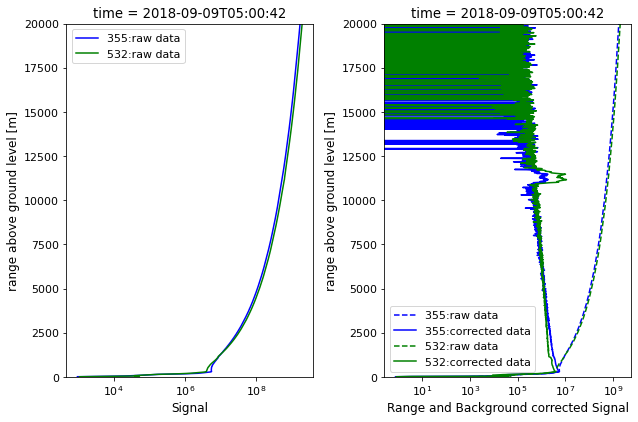

In [188]:
fig, (ax, ax2) = plt.subplots(figsize=(9,6), ncols=2)
data['rcs_12'].isel(time=585, range=limitez).plot(y='range', ax=ax, xscale='log', ylim=(0,20000), label='355:raw data', color='b')
data['rcs_16'].isel(time=585, range=limitez).plot(y='range', ax=ax, xscale='log', ylim=(0,20000), label='532:raw data', color='g')
ax.legend()
ax.set(xlabel='Signal')
data['rcs_12'].isel(time=585, range=limitez).plot(y='range', ax=ax2, xscale='log', ylim=(0,20000), label=f'355:raw data', color='b', linestyle='--')
datacorrecteds = (data['rcs_12']/np.square(data['range']) - data['bckgrd_'+'rcs_12'])*np.square(data['range'])
datacorrecteds.isel(time=585, range=limitez).plot(y='range', ax=ax2, xscale='log', ylim=(0,20000), label=f'355:corrected data', color='b')

data['rcs_16'].isel(time=585, range=limitez).plot(y='range', ax=ax2, xscale='log', ylim=(0,20000), label=f'532:raw data', color='g', linestyle='--')
datacorrecteds = (data['rcs_16']/np.square(data['range']) - data['bckgrd_'+'rcs_16'])*np.square(data['range'])
datacorrecteds.isel(time=585, range=limitez).plot(y='range', ax=ax2, xscale='log', ylim=(0,20000), label=f'532:corrected data', color='g')
ax2.legend()
ax2.set(xlabel='Range and Background corrected Signal')
plt.tight_layout()

In [60]:
datacorrected = datacorrected.sel(time=slice(dateStart, dateEnd))

__Crit 1: Enlever les profils ayant plus de signaux en haut qu'en bas__

Comparer entre la valeur moyennée du signal dans une zone indiquée à haute altitude et à basse altitude, flagger si cette valeur est plus grande en haut qu'en bas,

In [61]:
def filter_profile_file(filecorrected, channel, limiteTop, limiteBottom):
    '''
    Critere 1: flagger si le signal en haut plus qu'en bas
    Input: 
        raw: range & background corrected signal
        channel: canal utilisé
        limiteTop: la zone à haute altitude pour le filtre
        limiteBottom: la zone à basse altitude pour le filtre
    Output:
        index_mask: index indiquant des profils validés/invalidés 
    '''
    # 1. MEAN TOP AND BOTTOM SIGNAL
    limite = (filecorrected['range']>limiteTop[0]) & (filecorrected['range']<limiteTop[1])
    meanTop = filecorrected.isel(range=limite).mean(dim='range')
    limite = (filecorrected['range']>limiteBottom[0]) & (filecorrected['range']<limiteBottom[1])
    meanBottom = filecorrected.isel(range=limite).mean(dim='range')
    # 2. GETTING GOOD PROFILE #selectionner le profil correct
    index_mask = (meanTop-meanBottom) < 0 # attention si meantop-meanBottom vient du raw (sélectionner channel) ou filecorrected (pas selectionner channel) 
    return index_mask

In [62]:
print(f'{len(datacorrected.time.values)} profils total dans ce fichier Ipral')
# entrer les zones indiquées
range_limite_top = [26000,28000]
range_limite_bottom = [2000,3000]
# appliquer le filtre 1
mask_crit1 = filter_profile_file(datacorrected, rcs_channel, range_limite_top, range_limite_bottom)
print(mask_crit1)
# bool array to index array
id_crit1 = np.where(mask_crit1)[0]
print(f'{(id_crit1)} profils gardés selon CRIT 1')
# variable pour les profils invalides
id_invalid_crit1 = np.where(mask_crit1==False)[0]
print(f'{len(id_invalid_crit1)} profils jetés selon CRIT 1')

2751 profils total dans ce fichier Ipral
<xarray.DataArray (time: 2751)>
array([ True,  True,  True, ...,  True,  True,  True])
Coordinates:
  * time     (time) datetime64[ns] 2018-09-09T00:00:20 ... 2018-09-09T23:59:21
[   0    1    2 ... 2748 2749 2750] profils gardés selon CRIT 1
0 profils jetés selon CRIT 1


Illustration: __quicklook Range and Background corrected signal non filtré__

[Text(0.5, 1.0, 'ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440 (initial)')]

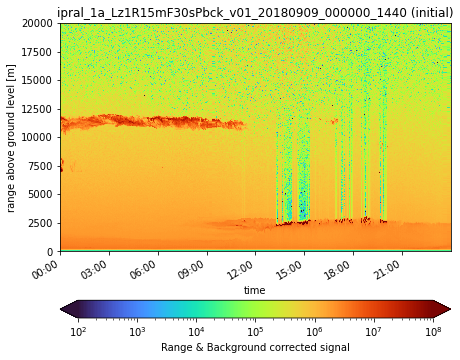

In [101]:

fig, ax = plt.subplots(figsize=(7,6))
datacorrected.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), ax=ax, robust=True, cmap='turbo',
                   ylim=(0,20000), cbar_kwargs={'label':'Range & Background corrected signal',
                                               'orientation':'horizontal'})
# ax.scatter(datacorrected[index_mask]['time'].values, [19000]*len(datacorrected[index_mask]['time'].values), color='y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title=f'{filepath.stem} (initial)')


Illustration: __Plot des profils mauvais__

Constater que ces profils augmentent en fonction de l'altitude, donc c'est irréel. Ils sont tous enlenver. 

In [102]:
# limitez = datacorrected['range'] < 20000
# datacorrected.isel(time=id_invalid_crit1).plot.line(y='range', col='time', col_wrap=3, ylim=(0,30000))

Illustration: __le QL filtré__

[Text(0.5, 1.0, 'filtre 1: garder les profils diminués en fonction de l altitude')]

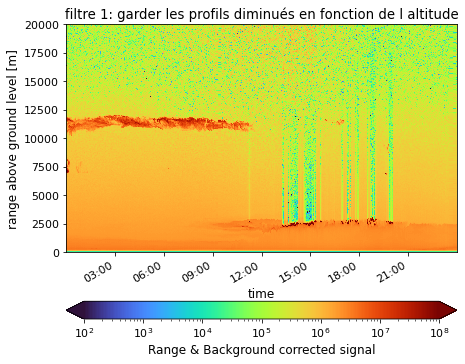

In [63]:
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
Data1 = datacorrected.where(mask_crit1, drop=False)
fig, ax = plt.subplots(figsize=(7,6))
Data1.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), ax=ax, robust=True, cmap='turbo',
           ylim=(0,20000), cbar_kwargs={'label':'Range & Background corrected signal',
                                               'orientation':'horizontal'})
# ax.scatter(datacorrected[index_mask]['time'].values, [19000]*len(datacorrected[index_mask]['time'].values), color='y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title=f'filtre 1: garder les profils diminués en fonction de l altitude')

__*Stocker ces index des profils validés dans une variable:*__ id_crit1

__Crit 2: Enveler les profils ayant trop de valeurs NaN et bizarres__

Etape 1: calculer la proportion des valeurs invalides par profil

In [4]:
def proportion_values_profile(dataipral):
    nb_nonzero = ((dataipral>0) & ~np.isnan(dataipral)).sum(axis=1)
    nb_points_by_profile = dataipral.shape[1]
    fraction_nonzero = nb_nonzero/nb_points_by_profile   
    return fraction_nonzero
    
# index_mask = fraction_nonzero > 0.7  #selectionner le profil correct    
# index_mask
# datacorrected[index_mask]

In [11]:
#----------------------------------------------------
# sur tous les fichiers 
all_validated_profile = None
IPRAL_LISTFILES = sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))

import tqdm
for filepath in tqdm.tqdm(IPRAL_LISTFILES):
    data = xr.open_dataset(filepath)
    datacorrecteds = (data[rcs_channel]/np.square(data['range']) - data['bckgrd_'+rcs_channel])*np.square(data['range'])
    limitez = (data['range']<20000)
    if (all_validated_profile is None):
        all_validated_profile = proportion_values_profile(datacorrecteds.isel(range=limitez))
    else:
        all_validated_profile = xr.concat([all_validated_profile, proportion_values_profile(datacorrecteds.isel(range=limitez))], dim='time')


100%|██████████| 120/120 [12:37<00:00,  6.31s/it]


Etape 2: Calculer le seuil de définition des profils invalides

In [12]:
all_validated_profile.to_dataframe('proportion').describe()

proportion
count  189234.000000
mean        0.821112
std         0.117202
min         0.274569
25%         0.765941
50%         0.837959
75%         0.919730
max         0.991748

In [13]:
mean_seuil = all_validated_profile.mean().values
print(f'{mean_seuil}', file=open('ipral_validated_profiles_seuil_mean.txt', 'a'))

Text(0.5, 0, 'fraction')

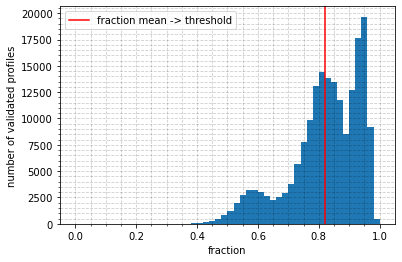

In [14]:
# Histogramme de la distribution des proportions sur une base de données avec le seuil 
plt.hist(all_validated_profile, range=[0.0, 1.0], bins=50)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.2)
plt.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
plt.axvline(mean_seuil, color='r', label='fraction mean -> threshold')
plt.legend()
plt.ylabel('number of validated profiles')
plt.xlabel('fraction')

Etape 3: Appliquer le filtre avec ce seuil ci-dessus et trouver les profils satisfaisants à cette critère 2.

In [5]:
def validated_profile(dataipral): 
    nb_nonzero = ((dataipral>0) & ~np.isnan(dataipral)).sum(axis=1)
    nb_points_by_profile = dataipral.shape[1]
    fraction_nonzero = nb_nonzero/nb_points_by_profile
    seuil = np.mean(fraction_nonzero.values)
    index_mask = fraction_nonzero > seuil  #selectionner le profil correct    
    return fraction_nonzero, index_mask

In [6]:
fraction_test, id_crit2 = validated_profile(datacorrected.isel(range=limitez))
# fraction_test, len(np.where(id_crit2)[0]), id_crit2

Illustration: __le QL de RCS avant d être filtré et l'évolution de la proportion__

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'proportion of validared values per profile'),
 Text(0.5, 1.0, 'ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440')]

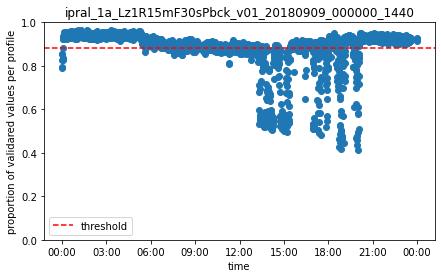

In [175]:
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
fig, ax2 = plt.subplots(figsize=(7,4))
# fraction_test.plot(x='time', ax=ax2,marker="o")
ax2.scatter(fraction_test['time'].values, fraction_test.values)
ax2.axhline(np.mean(fraction_test.values), linestyle='--', color='red', label='threshold')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_ylim(0.0, 1.0)
ax2.legend()
ax2.set(xlabel='time', ylabel='proportion of validared values per profile', 
        title=f'{filepath.stem}')

Illustration: __le QL filtré__

[Text(0.5, 1.0, 'filtre 2: garder les profils ayant proportion des valeurs signficatives > seuil')]

<Figure size 432x288 with 0 Axes>

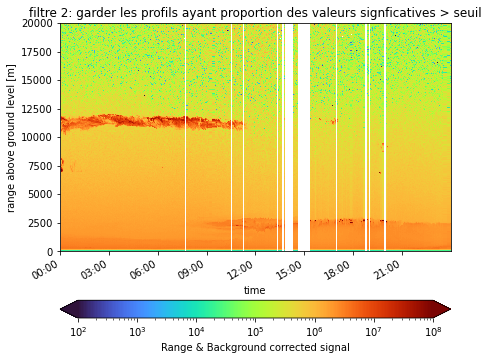

In [9]:
Data2 = datacorrected.where(id_crit2, drop=False) # creer un masque 0/1 ou True/False pour where 

plt.clf()
fig, ax = plt.subplots(figsize=(7,6))
Data2.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), ax=ax, robust=True,cmap='turbo',
                   ylim=(0,20000), cbar_kwargs={'label':'Range & Background corrected signal', 'orientation':'horizontal'})
# ax.scatter(datacorrected[index_mask]['time'].values, [19000]*len(datacorrected[index_mask]['time'].values), color='y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title=f'filtre 2: garder les profils ayant proportion des valeurs signficatives > seuil')


Voir ces proportions spécifiquement du cas 2018-11-06, on peut aussi faire des statistiques pour déterminer un seuil individuel pour chacun du cas de jour.  

__*Stocker ces index des profils validés dans une variable:*__ id_crit2

In [68]:
id_crit2 = np.where(id_crit2)[0]

__Crit 3: Filtrer les nuages à basse altitude avec le filtre de Marc Antoine__

In [119]:

def ipral_remove_cloud_profiles(alt_max, ipral_file):
    import sys
    """
    Remove IPRAL profiles containing cloud below a defined altitude.

    Parameters
    ----------
    date : datetime.datetime
        The date of the file to process.
    alt_max : float
        The maximum altitude of clouds in meters.
    ipral_file : str or pathlib.Path
        The path of the IPRAL file to process.
    output : str or pathlib.Path
        The path to th eoutput file.

    """    
    CHM15K_PATH = Path('/backupfs/sirta/pub/basesirta/1a/chm15k')#Path("/bdd/SIRTA/pub/basesirta/1a/chm15k")
#     CHM15K_MASK = 'chm15k_1a_z1Ppr2R15mF15s_v01_*_1440.nc"
    CHM15K_TIME_RES = "15s"

    IPRAL_PATH = Path("/bdd/SIRTA/pub/basesirta/1a/ipral/")
    IPRAL_MASK = "ipral_1a_Lz1R15mF30sPbck_v01_*_1440.nc"
    IPRAL_TIME_RES = "30s"

    DATE_FMT = "days since 1970-01-01T00:00:00"
    ONE_DAY = datetime.timedelta(hours=23, minutes=59, seconds=59)
#     print(f"Processing {date:%Y-%m-%d}")
    print(f"Removing IPRAL profiles with clouds below {alt_max:7.1f}")
    # read CHM15k file
    # ---------------------------------------------------------------------------------
    date = ipral_file.name.split('_')[4]
    chm15k_file = sorted(CHM15K_PATH.glob(f'**/**/**/chm15k_1a_z1Ppr2R15mF15s_v01_{date}_000000_1440.nc'))
    if not chm15k_file:
        print("No CHM15k file found.")
        print("Quitting.")
        sys.exit(1)

    chm15k_file = chm15k_file[0]
    print(f"CHM15k file found: {chm15k_file}")
    cbh = xr.open_dataset(chm15k_file)["cloud_base_height"][:, 0]#.to_dataframe()["cloud_base_height"]
    # before rounding time, find clouds under the chosen altitude
    cbh_raw = cbh#(cbh > alt_max) | np.isnan(cbh)
    # ---------------------------------------------------------------------------------
    # round time to 15s to ease use
    cbh['time'] = cbh['time'].dt.round(freq=CHM15K_TIME_RES)
#     cbh.index = cbh.index.round(freq=CHM15K_TIME_RES)
    # under sample chm15k data to 30s to have the time resolution as ipral
    cbh = cbh.resample(time=IPRAL_TIME_RES).first()

    # read IPRAL data
    # ----------------
    date = pd.to_datetime(date)
    ipral_data = xr.open_dataset(ipral_file).sel(time=slice(date, date + ONE_DAY))
    raw_profs = ipral_data.time.size
    print(f"{raw_profs} in IPRAL data")

    # get cloud mask
    # ---------------
    # round time to 30s to ease use
#     ipral_time = ipral_data.time.to_dataframe().index.round(freq=IPRAL_TIME_RES)
    ipral_time = ipral_data['time'].dt.round(freq=IPRAL_TIME_RES)
    # only keep timesteps of CBH available in ipral data
#     cbh = cbh.loc[ipral_time]
    cbh = cbh.sel(time=ipral_time)
    # create to only keep data without cloud under the chosen altitude
    cbh_mask = (cbh > alt_max) | np.isnan(cbh)
    profs_to_keep = cbh_mask.values.astype("i2").sum()
    print(f"{raw_profs - profs_to_keep} profiles will be remove")
    # ---------------------------------------------------------------------------------

    # apply mask
    # ---------------------------------------------------------------------------------
    cbh_mask['time'] = ipral_data['time']
    return cbh_mask, cbh_raw

In [120]:
def ipral_remove_cloud_profiles_v2(alt_max, ipral_file):  
    import sys
    date = ipral_file.name.split('_')[4]
    # read CHM15k file
    # ----------------
    CHM15K_PATH = Path('/backupfs/sirta/pub/basesirta/1a/chm15k')#Path("/bdd/SIRTA/pub/basesirta/1a/chm15k")
    chm15k_file = sorted(CHM15K_PATH.glob(f'**/**/**/chm15k_1a_z1Ppr2R15mF15s_v01_{date}_000000_1440.nc'))
    if not chm15k_file:
        print("No CHM15k file found.")
        print("Quitting.")
        sys.exit()

    chm15k_file = chm15k_file[0]
    print(f"CHM15k file found: {chm15k_file}")
    df_cbh = xr.open_dataset(chm15k_file)["cloud_base_height"][:, 0].to_dataframe()#["cloud_base_height"]
    # read IPRAL data
    # ----------------
    ipral_data = xr.open_dataset(ipral_file)
    ipral_time_array = ipral_data['time'].values
    # get cloud height
    # ---------------    
    cloud_height_array = np.zeros_like(ipral_time_array, dtype='float')    
    for j in range(len(ipral_time_array)):
        print(ipral_time_array[j])
        print(df_cbh.iloc[df_cbh.index.get_loc(ipral_time_array[j], method='nearest')])
        cloud_height_array[j] = df_cbh.iloc[df_cbh.index.get_loc(ipral_time_array[j], method='nearest')]['cloud_base_height']
    
    cloud_over_altmax = (cloud_height_array > alt_max)#|np.isnan(cloud_height_array)
    cloud_mask_xarray = xr.DataArray(data=cloud_over_altmax, 
                                     dims=['time'], 
                                     coords=dict(time=ipral_time_array))
    print(f"{len(ipral_time_array)} in IPRAL data")
    profs_to_keep = cloud_over_altmax.astype("i2").sum()
    print(f"{len(ipral_time_array) - profs_to_keep} profiles will be remove")
    return cloud_mask_xarray

Attention: ce filtre pourrait être appliqué sur des données ayant ou non calibrées, car il se base sur le ceilomètre pour rendre l'index des profils validés.

Etape 1: Appliquer ce filtre sur un dataset (un fichier)
L'altitude choisie est 4km, donc le filtre va chercher et indiquer les profils n'ont pas de nuages __*(cbh=Nan)*__ ou possèdent des nuages > 4km __*(cbh > 4km)*__. 

In [121]:
filepath = sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc'))[0]
mask_profile, mask_raw = ipral_remove_cloud_profiles(4000, filepath)
id_crit3 = np.where(mask_profile)[0]

mask_profile = ipral_remove_cloud_profiles_v2(4000, filepath)
id_crit3 = np.where(mask_profile)[0]

Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /backupfs/sirta/pub/basesirta/1a/chm15k/2018/09/09/chm15k_1a_z1Ppr2R15mF15s_v01_20180909_000000_1440.nc
2751 in IPRAL data
477 profiles will be remove
CHM15k file found: /backupfs/sirta/pub/basesirta/1a/chm15k/2018/09/09/chm15k_1a_z1Ppr2R15mF15s_v01_20180909_000000_1440.nc
2018-09-08T23:59:49.999999744
layer                   1.0
cloud_base_height    6866.0
Name: 2018-09-09 00:00:13, dtype: float64
2018-09-09T00:00:20.000000000
layer                   1.0
cloud_base_height    6866.0
Name: 2018-09-09 00:00:13, dtype: float64
2018-09-09T00:00:50.000000000
layer                   1.0
cloud_base_height    6867.0
Name: 2018-09-09 00:00:43, dtype: float64
2018-09-09T00:01:21.000000000
layer                   1.0
cloud_base_height    6869.0
Name: 2018-09-09 00:01:28.000000256, dtype: float64
2018-09-09T00:01:50.999999744
layer                   1.0
cloud_base_height    6878.0
Name: 2018-09-09 00:01:58, dtype: float64
2018-09

2018-09-09T01:49:54.000000000
layer                    1.0
cloud_base_height    10984.0
Name: 2018-09-09 01:49:58, dtype: float64
2018-09-09T01:50:24.000000000
layer                    1.0
cloud_base_height    10984.0
Name: 2018-09-09 01:50:28, dtype: float64
2018-09-09T01:50:54.000000000
layer                    1.0
cloud_base_height    10986.0
Name: 2018-09-09 01:50:58.000000256, dtype: float64
2018-09-09T01:51:25.000000256
layer                    1.0
cloud_base_height    10984.0
Name: 2018-09-09 01:51:28, dtype: float64
2018-09-09T01:51:55.000000000
layer                    1.0
cloud_base_height    10984.0
Name: 2018-09-09 01:51:58, dtype: float64
2018-09-09T01:52:25.000000000
layer                    1.0
cloud_base_height    10984.0
Name: 2018-09-09 01:52:27.999999744, dtype: float64
2018-09-09T01:52:54.999999744
layer                    1.0
cloud_base_height    10984.0
Name: 2018-09-09 01:52:58, dtype: float64
2018-09-09T01:53:26.000000256
layer                    1.0
cloud_base_

layer                    1.0
cloud_base_height    10774.0
Name: 2018-09-09 05:52:28, dtype: float64
2018-09-09T05:52:51.000000000
layer                    1.0
cloud_base_height    10774.0
Name: 2018-09-09 05:52:58, dtype: float64
2018-09-09T05:53:22.000000000
layer                    1.0
cloud_base_height    10774.0
Name: 2018-09-09 05:53:27.999999744, dtype: float64
2018-09-09T05:53:52.000000000
layer                    1.0
cloud_base_height    10776.0
Name: 2018-09-09 05:53:58, dtype: float64
2018-09-09T05:54:22.000000000
layer                    1.0
cloud_base_height    10776.0
Name: 2018-09-09 05:54:28, dtype: float64
2018-09-09T05:54:52.000000000
layer                    1.0
cloud_base_height    10776.0
Name: 2018-09-09 05:54:58, dtype: float64
2018-09-09T05:55:23.000000000
layer                    1.0
cloud_base_height    10778.0
Name: 2018-09-09 05:55:28, dtype: float64
2018-09-09T05:55:53.000000000
layer                    1.0
cloud_base_height    10789.0
Name: 2018-09-09 05:55

Name: 2018-09-09 06:29:43, dtype: float64
2018-09-09T06:30:12.999999744
layer                    1.0
cloud_base_height    11044.0
Name: 2018-09-09 06:30:12.999999744, dtype: float64
2018-09-09T06:30:43.000000000
layer                    1.0
cloud_base_height    11044.0
Name: 2018-09-09 06:30:43, dtype: float64
2018-09-09T06:31:13.000000000
layer                    1.0
cloud_base_height    11044.0
Name: 2018-09-09 06:31:13, dtype: float64
2018-09-09T06:31:43.000000000
layer                    1.0
cloud_base_height    11029.0
Name: 2018-09-09 06:31:43, dtype: float64
2018-09-09T06:32:14.000000000
layer                    1.0
cloud_base_height    11029.0
Name: 2018-09-09 06:32:13.000000256, dtype: float64
2018-09-09T06:32:44.000000000
layer                    1.0
cloud_base_height    11029.0
Name: 2018-09-09 06:32:43, dtype: float64
2018-09-09T06:33:14.000000000
layer                    1.0
cloud_base_height    11029.0
Name: 2018-09-09 06:33:13, dtype: float64
2018-09-09T06:33:45.00000000

Name: 2018-09-09 08:33:28, dtype: float64
2018-09-09T08:33:53.000000000
layer                    1.0
cloud_base_height    11329.0
Name: 2018-09-09 08:33:57.999999744, dtype: float64
2018-09-09T08:34:24.000000000
layer                    1.0
cloud_base_height    11329.0
Name: 2018-09-09 08:34:28, dtype: float64
2018-09-09T08:34:54.000000000
layer                    1.0
cloud_base_height    11329.0
Name: 2018-09-09 08:34:58, dtype: float64
2018-09-09T08:35:24.000000000
layer                    1.0
cloud_base_height    11329.0
Name: 2018-09-09 08:35:28, dtype: float64
2018-09-09T08:35:55.000000000
layer                    1.0
cloud_base_height    11329.0
Name: 2018-09-09 08:35:58.000000256, dtype: float64
2018-09-09T08:36:25.000000256
layer                    1.0
cloud_base_height    11314.0
Name: 2018-09-09 08:36:28, dtype: float64
2018-09-09T08:36:55.000000000
layer                    1.0
cloud_base_height    11329.0
Name: 2018-09-09 08:36:58, dtype: float64
2018-09-09T08:37:25.00000000

2018-09-09T10:21:50.000000256
layer                    1.0
cloud_base_height    10774.0
Name: 2018-09-09 10:21:42.999999744, dtype: float64
2018-09-09T10:22:20.000000000
layer                    1.0
cloud_base_height    10774.0
Name: 2018-09-09 10:22:13, dtype: float64
2018-09-09T10:22:51.000000000
layer                    1.0
cloud_base_height    10744.0
Name: 2018-09-09 10:22:58, dtype: float64
2018-09-09T10:23:21.000000000
layer                    1.0
cloud_base_height    10699.0
Name: 2018-09-09 10:23:27.999999744, dtype: float64
2018-09-09T10:23:51.000000256
layer                    1.0
cloud_base_height    10714.0
Name: 2018-09-09 10:23:58, dtype: float64
2018-09-09T10:24:22.000000000
layer                    1.0
cloud_base_height    10699.0
Name: 2018-09-09 10:24:28, dtype: float64
2018-09-09T10:24:52.000000000
layer                    1.0
cloud_base_height    10699.0
Name: 2018-09-09 10:24:58, dtype: float64
2018-09-09T10:25:22.000000000
layer                    1.0
cloud_base_

2018-09-09T11:06:46.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:06:42.999999744, dtype: float64
2018-09-09T11:07:16.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:07:13, dtype: float64
2018-09-09T11:07:46.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:07:43, dtype: float64
2018-09-09T11:08:17.000000000
layer                    1.0
cloud_base_height    11119.0
Name: 2018-09-09 11:08:13, dtype: float64
2018-09-09T11:08:47.000000000
layer                    1.0
cloud_base_height    11119.0
Name: 2018-09-09 11:08:43.000000256, dtype: float64
2018-09-09T11:09:17.000000000
layer                    1.0
cloud_base_height    11119.0
Name: 2018-09-09 11:09:13, dtype: float64
2018-09-09T11:09:47.000000000
layer                    1.0
cloud_base_height    11119.0
Name: 2018-09-09 11:09:43, dtype: float64
2018-09-09T11:10:18.000000000
layer                    1.0
cloud_base_height    11104.0
Name: 

2018-09-09T11:53:11.999999744
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:53:13, dtype: float64
2018-09-09T11:53:43.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:53:43.000000256, dtype: float64
2018-09-09T11:54:13.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:54:13, dtype: float64
2018-09-09T11:54:43.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:54:43, dtype: float64
2018-09-09T11:55:14.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:55:12.999999744, dtype: float64
2018-09-09T11:55:44.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:55:43, dtype: float64
2018-09-09T11:56:14.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:56:13, dtype: float64
2018-09-09T11:56:44.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 11:56:43.000000256, dtype: fl

layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 12:59:12.999999744, dtype: float64
2018-09-09T12:59:50.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 12:59:43, dtype: float64
2018-09-09T13:00:21.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:00:28, dtype: float64
2018-09-09T13:00:51.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:00:57.999999744, dtype: float64
2018-09-09T13:01:21.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:01:28, dtype: float64
2018-09-09T13:01:52.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:01:58, dtype: float64
2018-09-09T13:02:22.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:02:28, dtype: float64
2018-09-09T13:02:52.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:02:58, dtype: float64
2018-09-09T13:03:22.000000256
laye

Name: 2018-09-09 13:33:43, dtype: float64
2018-09-09T13:34:10.000000000
layer                   1.0
cloud_base_height    2243.0
Name: 2018-09-09 13:34:13, dtype: float64
2018-09-09T13:34:40.000000000
layer                   1.0
cloud_base_height    2241.0
Name: 2018-09-09 13:34:42.999999744, dtype: float64
2018-09-09T13:35:11.000000000
layer                   1.0
cloud_base_height    2235.0
Name: 2018-09-09 13:35:13, dtype: float64
2018-09-09T13:35:41.000000256
layer                   1.0
cloud_base_height    2248.0
Name: 2018-09-09 13:35:43, dtype: float64
2018-09-09T13:36:11.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:36:13, dtype: float64
2018-09-09T13:36:41.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:36:43, dtype: float64
2018-09-09T13:37:12.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 13:37:13, dtype: float64
2018-09-09T13:37:42.000000256
layer                1.0
cloud_base_heig

Name: 2018-09-09 14:20:13, dtype: float64
2018-09-09T14:20:36.000000000
layer                   1.0
cloud_base_height    2468.0
Name: 2018-09-09 14:20:43, dtype: float64
2018-09-09T14:21:07.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 14:21:13, dtype: float64
2018-09-09T14:21:37.000000000
layer                   1.0
cloud_base_height    2454.0
Name: 2018-09-09 14:21:43, dtype: float64
2018-09-09T14:22:07.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 14:22:13, dtype: float64
2018-09-09T14:22:38.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 14:22:42.999999744, dtype: float64
2018-09-09T14:23:08.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 14:23:13, dtype: float64
2018-09-09T14:23:38.000000000
layer                   1.0
cloud_base_height    2460.0
Name: 2018-09-09 14:23:43, dtype: float64
2018-09-09T14:24:09.000000000
layer                1.0
cloud_base_height    

Name: 2018-09-09 15:19:43, dtype: float64
2018-09-09T15:20:11.000000000
layer                   1.0
cloud_base_height    2626.0
Name: 2018-09-09 15:20:13, dtype: float64
2018-09-09T15:20:41.000000000
layer                   1.0
cloud_base_height    2603.0
Name: 2018-09-09 15:20:42.999999744, dtype: float64
2018-09-09T15:21:11.000000000
layer                   1.0
cloud_base_height    2605.0
Name: 2018-09-09 15:21:13, dtype: float64
2018-09-09T15:21:42.000000000
layer                   1.0
cloud_base_height    2649.0
Name: 2018-09-09 15:21:43, dtype: float64
2018-09-09T15:22:12.000000000
layer                   1.0
cloud_base_height    2621.0
Name: 2018-09-09 15:22:13, dtype: float64
2018-09-09T15:22:42.000000000
layer                   1.0
cloud_base_height    2679.0
Name: 2018-09-09 15:22:43, dtype: float64
2018-09-09T15:23:13.000000000
layer                   1.0
cloud_base_height    2692.0
Name: 2018-09-09 15:23:13, dtype: float64
2018-09-09T15:23:43.000000000
layer                 

Name: 2018-09-09 16:12:43, dtype: float64
2018-09-09T16:13:11.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 16:13:13, dtype: float64
2018-09-09T16:13:41.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 16:13:43, dtype: float64
2018-09-09T16:14:12.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 16:14:13, dtype: float64
2018-09-09T16:14:42.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 16:14:43, dtype: float64
2018-09-09T16:15:12.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 16:15:12.999999744, dtype: float64
2018-09-09T16:15:43.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 16:15:43, dtype: float64
2018-09-09T16:16:13.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 16:16:13, dtype: float64
2018-09-09T16:16:43.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-

layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 17:42:28.000000256, dtype: float64
2018-09-09T17:43:03.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 17:42:58, dtype: float64
2018-09-09T17:43:33.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 17:43:28, dtype: float64
2018-09-09T17:44:03.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 17:43:57.999999744, dtype: float64
2018-09-09T17:44:32.999999744
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 17:44:28, dtype: float64
2018-09-09T17:45:04.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 17:44:58, dtype: float64
2018-09-09T17:45:34.000000000
layer                   1.0
cloud_base_height    2806.0
Name: 2018-09-09 17:45:28.000000256, dtype: float64
2018-09-09T17:46:04.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 17:45:58, dtype: float64
2018-09-09T17:46:3

2018-09-09T18:17:52.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:17:58, dtype: float64
2018-09-09T18:18:23.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:18:28, dtype: float64
2018-09-09T18:18:53.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:18:57.999999744, dtype: float64
2018-09-09T18:19:23.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:19:28, dtype: float64
2018-09-09T18:19:54.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:19:58, dtype: float64
2018-09-09T18:20:24.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:20:28, dtype: float64
2018-09-09T18:20:54.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:20:58.000000256, dtype: float64
2018-09-09T18:21:24.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:21:28, dtype: float64
2018

2018-09-09T18:52:42.999999744
layer                   1.0
cloud_base_height    2369.0
Name: 2018-09-09 18:52:42.999999744, dtype: float64
2018-09-09T18:53:13.000000000
layer                   1.0
cloud_base_height    2334.0
Name: 2018-09-09 18:53:13, dtype: float64
2018-09-09T18:53:43.000000000
layer                   1.0
cloud_base_height    2347.0
Name: 2018-09-09 18:53:43, dtype: float64
2018-09-09T18:54:13.000000000
layer                   1.0
cloud_base_height    2653.0
Name: 2018-09-09 18:54:13, dtype: float64
2018-09-09T18:54:44.000000000
layer                   1.0
cloud_base_height    2787.0
Name: 2018-09-09 18:54:43.000000256, dtype: float64
2018-09-09T18:55:14.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:55:13, dtype: float64
2018-09-09T18:55:44.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 18:55:43, dtype: float64
2018-09-09T18:57:53.000000000
layer                   1.0
cloud_base_height    2379.0
Name: 2018

Name: 2018-09-09 19:39:43.000000256, dtype: float64
2018-09-09T19:40:18.000000256
layer                   1.0
cloud_base_height    6823.0
Name: 2018-09-09 19:40:13, dtype: float64
2018-09-09T19:40:48.000000000
layer                   1.0
cloud_base_height    6822.0
Name: 2018-09-09 19:40:43, dtype: float64
2018-09-09T19:41:18.000000000
layer                   1.0
cloud_base_height    6822.0
Name: 2018-09-09 19:41:12.999999744, dtype: float64
2018-09-09T19:41:47.999999744
layer                   1.0
cloud_base_height    6819.0
Name: 2018-09-09 19:41:43, dtype: float64
2018-09-09T19:42:19.000000256
layer                   1.0
cloud_base_height    6808.0
Name: 2018-09-09 19:42:13, dtype: float64
2018-09-09T19:42:49.000000000
layer                   1.0
cloud_base_height    2648.0
Name: 2018-09-09 19:42:43.000000256, dtype: float64
2018-09-09T19:43:19.000000000
layer                   1.0
cloud_base_height    2482.0
Name: 2018-09-09 19:43:13, dtype: float64
2018-09-09T19:43:50.000000000
la

Name: 2018-09-09 20:43:57.999999744, dtype: float64
2018-09-09T20:44:25.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 20:44:28, dtype: float64
2018-09-09T20:44:55.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 20:44:58, dtype: float64
2018-09-09T20:45:25.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 20:45:28.000000256, dtype: float64
2018-09-09T20:45:56.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 20:45:58, dtype: float64
2018-09-09T20:46:26.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 20:46:28, dtype: float64
2018-09-09T20:46:56.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 20:46:57.999999744, dtype: float64
2018-09-09T20:47:26.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 20:47:28, dtype: float64
2018-09-09T20:47:57.000000000
layer                1.0
cloud_base_height  

Name: 2018-09-09 21:41:58, dtype: float64
2018-09-09T21:42:28.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 21:42:28, dtype: float64
2018-09-09T21:42:59.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 21:42:58, dtype: float64
2018-09-09T21:43:29.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 21:43:28.000000256, dtype: float64
2018-09-09T21:43:59.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 21:43:58, dtype: float64
2018-09-09T21:44:30.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 21:44:28, dtype: float64
2018-09-09T21:45:00.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 21:44:57.999999744, dtype: float64
2018-09-09T21:45:30.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 21:45:28, dtype: float64
2018-09-09T21:46:00.000000000
layer                1.0
cloud_base_height    NaN
Name

Name: 2018-09-09 22:47:13, dtype: float64
2018-09-09T22:47:36.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 22:47:42.999999744, dtype: float64
2018-09-09T22:48:06.000000256
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 22:48:13, dtype: float64
2018-09-09T22:48:37.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 22:48:43, dtype: float64
2018-09-09T22:49:07.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 22:49:13.000000256, dtype: float64
2018-09-09T22:49:37.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 22:49:43, dtype: float64
2018-09-09T22:50:07.999999744
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 22:50:13, dtype: float64
2018-09-09T22:50:38.000000000
layer                1.0
cloud_base_height    NaN
Name: 2018-09-09 22:50:42.999999744, dtype: float64
2018-09-09T22:51:08.000000000
layer                1.0
cloud_base_height  

2752 in IPRAL data
1453 profiles will be remove


In [123]:
id_crit3

array([   0,    1,    2, ..., 2295, 2297, 2298])

Illustration: __Le QL en 2018-11-06 avant être filtrées__

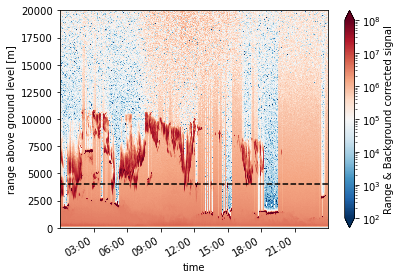

In [43]:
timeStart = pd.to_datetime('2018-11-06 12:00:00')
timeEnd = pd.to_datetime('2018-11-06 15:00:00')

from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
fig, ax = plt.subplots()
datacorrected.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), ylim=(0,20000), #xlim=(timeStart, timeEnd),
                                           cbar_kwargs={'label':'Range & Background corrected signal'})
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axhline(4000, linestyle='--', color='k')


Illustration: __Le QL filtré__

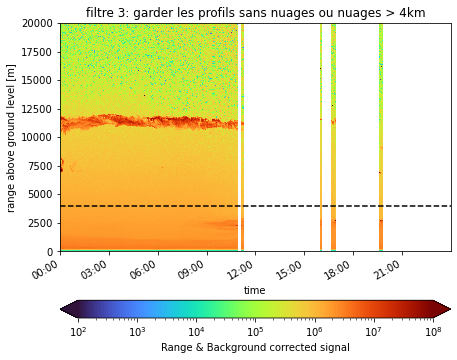

In [124]:
Data3 = datacorrected.where(mask_profile, drop=False)

fig, ax = plt.subplots(figsize=(7,6))
Data3.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), ylim=(0,20000), cmap='turbo',#xlim=(timeStart, timeEnd),
           cbar_kwargs={'label':'Range & Background corrected signal', 'orientation':'horizontal'})
ax.set(title='filtre 3: garder les profils sans nuages ou nuages > 4km')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axhline(4000, linestyle='--', color='k')


In [9]:
Data3 = datacorrected.where(mask_profile, drop=False)
pddf1 = mask_raw.to_dataframe('cloud_base_height')
# pddf2 = Data3.to_dataframe('mask_cloud')

cloud_heigh = np.zeros_like(Data3["time"].values, dtype='float')
for i in range(len(datacorrected["time"].values)):
#     print(f'Ipral {Data3["time"].values[i]}')
#     print(pddf1.iloc[pddf1.index.get_loc(Data3["time"].values[i], method='nearest')])
    cloud_heigh[i] = pddf1.iloc[pddf1.index.get_loc(datacorrected["time"].values[i], method='nearest')]['cloud_base_height']

In [14]:
Data3supp = datacorrected.where(datacorrected['time'].isin(datacorrected['time'].values[(cloud_heigh > 4000)]), drop=False)
#|(np.isnan(cloud_heigh))

(17841.0, 17841.999305555557)

<Figure size 432x288 with 0 Axes>

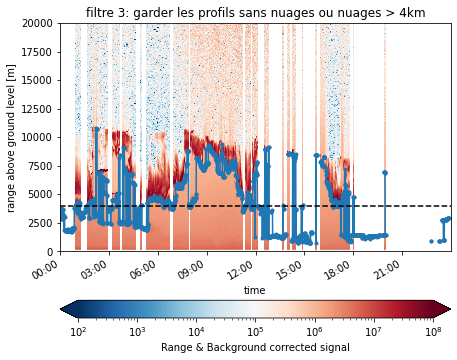

In [17]:
timeStart = pd.to_datetime('2018-11-06 00:00:00')
timeEnd = pd.to_datetime('2018-11-06 23:59:00')

plt.clf()
fig, ax = plt.subplots(figsize=(7,6))
Data3supp.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), ylim=(0,20000), xlim=(timeStart, timeEnd),
           cbar_kwargs={'label':'Range & Background corrected signal', 'orientation':'horizontal'})
ax.plot(datacorrected['time'].values, cloud_heigh, marker='.')
ax.set(title='filtre 3: garder les profils sans nuages ou nuages > 4km')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axhline(4000, linestyle='--', color='k')
ax.set_xlim(timeStart, timeEnd)

In [275]:

print(cloud_heigh[(datacorrected['time'].values > timeStart)&(datacorrected['time'].values < timeEnd)])
print(datacorrected['time'].values[(datacorrected['time'].values > timeStart)&(datacorrected['time'].values < timeEnd)])

[  nan   nan   nan   nan   nan 1166.   nan   nan   nan 1198.   nan 1208.
 1187. 1196. 1235.   nan 1212. 1197. 1163. 1133. 1188. 4000. 4065. 1420.
 1136. 1456. 1366.   nan   nan 1423.]
['2018-11-06T13:30:18.000000000' '2018-11-06T13:30:48.999999744'
 '2018-11-06T13:31:19.000000000' '2018-11-06T13:31:49.000000000'
 '2018-11-06T13:32:19.000000000' '2018-11-06T13:32:49.999999744'
 '2018-11-06T13:33:20.000000000' '2018-11-06T13:33:50.000000000'
 '2018-11-06T13:34:21.000000000' '2018-11-06T13:34:50.999999744'
 '2018-11-06T13:35:21.000000000' '2018-11-06T13:35:51.000000000'
 '2018-11-06T13:36:22.000000000' '2018-11-06T13:36:51.999999744'
 '2018-11-06T13:37:22.000000000' '2018-11-06T13:37:53.000000000'
 '2018-11-06T13:38:23.000000000' '2018-11-06T13:38:52.999999744'
 '2018-11-06T13:39:23.000000000' '2018-11-06T13:39:54.000000000'
 '2018-11-06T13:40:24.000000000' '2018-11-06T13:40:53.999999744'
 '2018-11-06T13:41:25.000000256' '2018-11-06T13:41:55.000000000'
 '2018-11-06T13:42:25.000000000' '20

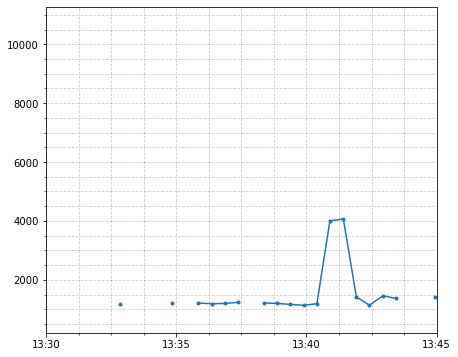

In [276]:
fig, ax = plt.subplots(figsize=(7,6))
ax.plot(datacorrected['time'].values, cloud_heigh, marker='.')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(timeStart, timeEnd)
plt.minorticks_on()
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.2)
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)

__*Stocker ces index des profils validés dans une variable:*__ id_crit3 = mask_profile

Profils finaux gardés
=============

L'objectif est de retourner l'ensemble des profils validés après les filtres pour intégrer à la suite dans l'étude statistique des SR

In [125]:
print(f'CRIT 1:{len(id_crit1)}, CRIT 2:{len(id_crit2)}, CRIT 3:{len(id_crit3)}')

CRIT 1:2752, CRIT 2:2076, CRIT 3:1299


In [126]:
id_total_mask = np.intersect1d(np.intersect1d(id_crit1, id_crit2, return_indices=True)[0],
                            id_crit3, return_indices=True)[0]

time_profil_to_save = datacorrected['time'][id_total_mask].values
print(f'{len(datacorrected.time.values)} profils en total')
print(f'{len(id_total_mask)} profils gardés après les filtres')

2752 profils en total
1150 profils gardés après les filtres


In [127]:
total_mask = np.zeros((len(datacorrected['time'].values),), dtype='bool')
total_mask[id_total_mask] = True
total_mask = xr.DataArray(data = total_mask, 
                          dims = ['time'],
                          coords = dict(time=datacorrected['time'].values),)
print(total_mask)

<xarray.DataArray (time: 2752)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2018-09-08T23:59:49.999999744 ... 2018-09-...


Illustration: __le QL final__

[Text(0.5, 1.0, 'ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440\n données totalement filtrées')]

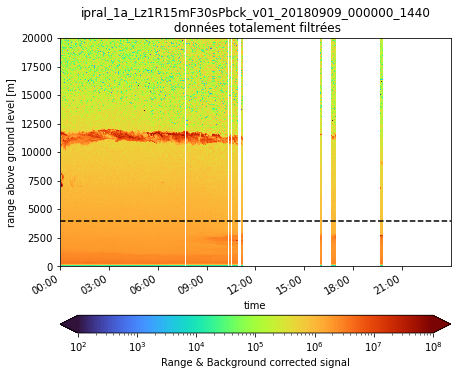

In [128]:
timeStart = pd.to_datetime('2018-11-06 00:00:00')
timeEnd = pd.to_datetime('2018-11-06 23:59:58')

Data_final = datacorrected.where(total_mask, drop=False)

fig, ax = plt.subplots(figsize=(7,6))
Data_final.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), cmap='turbo',
                ylim=(0,20000), #xlim=(timeStart, timeEnd), 
                cbar_kwargs={'label':'Range & Background corrected signal', 'orientation':'horizontal'})
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axhline(4000, linestyle='--', color='k')
ax.set(title=f'{filepath.stem}\n données totalement filtrées')

Moyennage des données
==================

Créer un compteur des profils dans un paquet de temps avant de moyennage 

In [185]:
print(f'{filepath}')
IPRAL_LISTFILES = sorted(Path(CALIB_PATH, 'zone-3000-4000').glob(f'{filepath.name}'))
wave = 532

filepath = IPRAL_LISTFILES[0]
filepath

/bdd/SIRTA/pub/basesirta/1a/ipral/2018/09/09/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc


PosixPath('/homedata/nmpnguyen/IPRAL/RF/Calibrated/zone-3000-4000/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc')

In [186]:
Data_final = xr.open_dataset(filepath)['calibrated'].sel(wavelength=wave).where(total_mask, drop=False)
Data_final

<xarray.DataArray 'calibrated' (time: 2751, range: 4000)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [ 7.41002472e-13,  4.10995929e-12,  1.77640806e-08, ...,
        -3.22960312e-06,  3.00164344e-07, -1.84662521e-06],
       [ 7.95119196e-13,  3.51810251e-12,  1.79212658e-08, ...,
        -2.33681498e-06, -1.18049802e-06, -2.14551592e-06],
       [ 8.09799484e-13,  3.37362766e-12,  1.80357043e-08, ...,
         1.18439748e-07, -7.77344299e-08, -1.75231074e-07]])
Coordinates:
  * time        (time) datetime64[ns] 2018-09-09T00:00:20 ... 2018-09-09T23:5...
  * range       (range) float32 15.0 30.0 45.0 ... 5.997e+04 5.998e+04 6e+04
    wavelength  int64 532

In [187]:
nb_profils_mean = Data_final.dropna(dim='time').resample(time='15min').count('time')
Data_final_mean = Data_final.dropna(dim='time').resample(time='15min', skipna=True).mean('time')

[Text(0.5, 1.0, 'ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440\n moyenner 15min')]

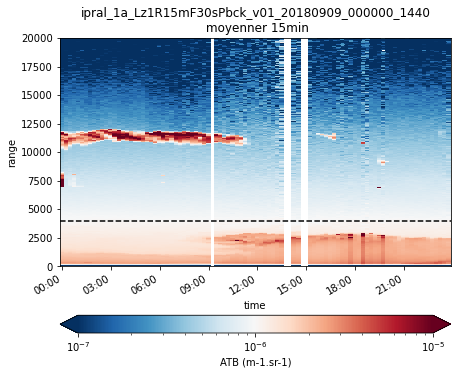

In [190]:
timeStart = pd.to_datetime('2018-12-14 00:00:00')
timeEnd = pd.to_datetime('2018-12-14 15:00:00')
fig, ax = plt.subplots(figsize=(7,6))
Data_final_mean.plot(x='time', y='range', norm=LogNorm(vmin=1e-7, vmax=1e-5), 
                ylim=(0,20000), #xlim=(timeStart, timeEnd), #cmap='turbo',
                cbar_kwargs={'label':'ATB (m-1.sr-1)', 'orientation':'horizontal'})
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axhline(4000, linestyle='--', color='k')
ax.set(title=f'{filepath.stem}\n moyenner 15min')

In [102]:
Data3_mean = Data3.dropna(dim='time').resample(time='15min', skipna=True).mean('time')
Data4 = Data3_mean.where(nb_profils_mean > int(30*0.25), np.nan)
# Data4.sel(time=slice(timeStart, timeEnd))

<Figure size 432x288 with 0 Axes>

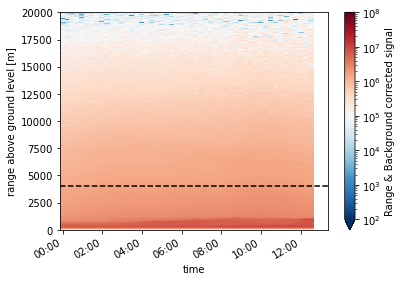

In [104]:
Data4 = Data_final_mean.where(nb_profils_mean > int(30*0.25), np.nan)
plt.clf()
fig, ax = plt.subplots()
Data4.plot(x='time', y='range', norm=LogNorm(vmin=1e2, vmax=1e8), 
                ylim=(0,20000), #xlim=(timeStart, timeEnd), #cmap='turbo',
                cbar_kwargs={'label':'Range & Background corrected signal'})
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axhline(4000, linestyle='--', color='k')

In [5]:
def processed(inputfolder, filepath, rangeLimiteZ, wave):
    data = xr.open_dataset(filepath)
    rcs_channel = 'rcs_12' if wave == 355 else 'rcs_16'
    datacorrected = (data[rcs_channel]/np.square(data['range']) - data['bckgrd_'+rcs_channel])*np.square(data['range'])
    # par CRIT 1
    range_limite_top = [26000,28000]
    range_limite_bottom = [2000,3000]
    mask_crit1 = filter_profile_file(datacorrected, rcs_channel, range_limite_top, range_limite_bottom)
    mask_crit1 = np.where(mask_crit1)[0]
    # par CRIT 2
    mask_crit2 = invalidated_profile(datacorrected.values)
    mask_crit2 = np.where(mask_crit2)[0]
    # par CRIT 3
    mask_crit3 = np.where(ipral_remove_cloud_profiles(4000, filepath))
    # id_Z = np.where((data['range']>rangeLimiteZ[0])&(data['range']<rangeLimiteZ[1]))[0]
    # mask_crit3 = flag_clouds(datacorrected, id_Z, filepath, wave=wave)
    # mask_crit3 = np.where(~mask_crit3)[0]
    # TOTAL INDICES
    total_mask = np.intersect1d(np.intersect1d(mask_crit1, mask_crit2, return_indices=True)[0], 
                                mask_crit3, return_indices=True)[0]
    time_to_save = data['time'][total_mask].values
    print(f'wave = {wave}\ntime to save : {time_to_save}')
    return time_to_save

## check clouds filter

In [431]:
# list_time = xr.open_dataset(filepath)['time'].values
# list_time_indice = pd.DataFrame([0]*len(list_time), index=list_time, columns=['indice'])
# list_time_indice['indice'].iloc[mask_profile]=1


In [59]:
CALIB_PATH = Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/')
filepath = sorted(CALIB_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_20181106_000000_1440.nc'))[0]
timeStart = pd.to_datetime('2018-11-06 15:00:00')
timeEnd = pd.to_datetime('2018-11-06 16:00:00')

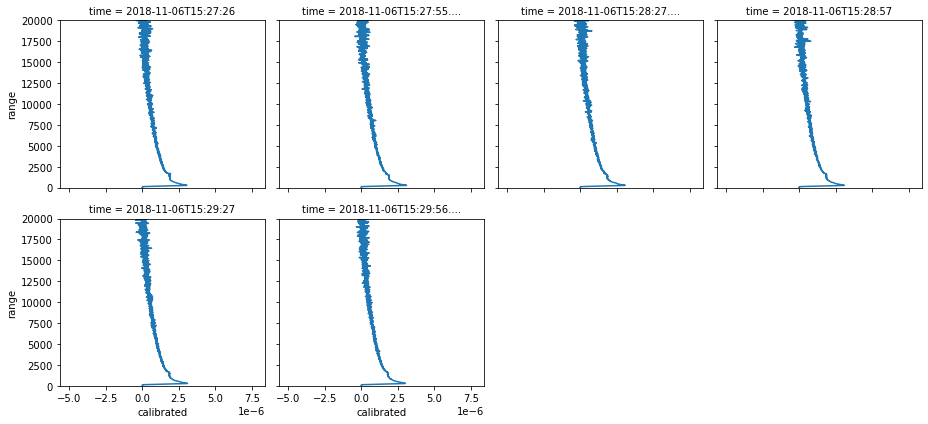

In [436]:
data_aftermask.isel(time = ((data_aftermask.time > timeStart) & (data_aftermask.time < pd.to_datetime('2018-11-06 15:30:00'))), wavelength=1)['calibrated'].plot.line(y='range', col='time', col_wrap=4, ylim=(0,20000))

In [437]:
# (data_aftermask.time > timeStart) & (data_aftermask.time < timeEnd)
data_aftermask.isel(time = ((data_aftermask.time > timeStart) & (data_aftermask.time < timeEnd)), wavelength=1, range=range(20,30)).resample(time='15min').mean()['calibrated']

<xarray.DataArray 'calibrated' (time: 3, range: 10)>
array([[2.97737771e-06, 2.92452322e-06, 2.87676242e-06, 2.82873694e-06,
        2.78489714e-06, 2.74863973e-06, 2.70613056e-06, 2.67416538e-06,
        2.63638354e-06, 2.60841498e-06],
       [2.96710532e-06, 2.91470882e-06, 2.86299928e-06, 2.81744232e-06,
        2.77329241e-06, 2.73159348e-06, 2.69262672e-06, 2.65673385e-06,
        2.62279688e-06, 2.59002066e-06],
       [2.86881253e-06, 2.81778321e-06, 2.77070755e-06, 2.72295446e-06,
        2.68238100e-06, 2.64181209e-06, 2.60328316e-06, 2.56917340e-06,
        2.53690380e-06, 2.50667652e-06]])
Coordinates:
  * time        (time) datetime64[ns] 2018-11-06T15:15:00 ... 2018-11-06T15:4...
  * range       (range) float32 315.0 330.0 345.0 360.0 ... 420.0 435.0 450.0
    wavelength  int64 532

In [438]:
profiles_validated1 = pd.read_csv('/scratchx/nmpnguyen/IPRAL/raw/detection_clouds_test/IPRAL_2018_validated_profiles1.csv')
profiles_validated1.iloc[112,]

Unnamed: 0       2018-11-06 00:56:28.999999744
Unnamed: 1       2018-11-06 00:56:59.000000000
Unnamed: 2       2018-11-06 00:57:30.000000000
Unnamed: 3       2018-11-06 00:58:00.000000000
Unnamed: 4       2018-11-06 00:58:29.999999744
                             ...              
Unnamed: 2817                              NaN
Unnamed: 2818                              NaN
Unnamed: 2819                              NaN
Unnamed: 2820                              NaN
Unnamed: 2821                              NaN
Name: 112, Length: 2822, dtype: object

In [439]:
ceilometer_before = pd.DataFrame(ceilometer_before, columns=['cloud_base_height']).astype(int)
ceilometer_after = pd.DataFrame(ceilometer_after, columns=['cloud_base_height'])
# ceilometer_before[(ceilometer_before.index > pd.to_datetime("2018-11-06 15:15:00"))&(ceilometer_before.index < pd.to_datetime("2018-11-06 15:30:00"))]
ceilometer_after[(ceilometer_after.index > pd.to_datetime("2018-11-06 15:15:00"))&(ceilometer_after.index < pd.to_datetime("2018-11-06 15:30:00"))]

cloud_base_height
time                                  
2018-11-06 15:15:30              810.0
2018-11-06 15:16:00              797.0
2018-11-06 15:16:30              798.0
2018-11-06 15:17:00              759.0
2018-11-06 15:17:30              972.0
2018-11-06 15:18:00              728.0
2018-11-06 15:18:30              738.0
2018-11-06 15:19:00              808.0
2018-11-06 15:19:30              758.0
2018-11-06 15:20:00              733.0
2018-11-06 15:20:30              809.0
2018-11-06 15:21:00              812.0
2018-11-06 15:21:30              716.0
2018-11-06 15:22:00              746.0
2018-11-06 15:22:30              823.0
2018-11-06 15:23:00             1630.0
2018-11-06 15:23:30             1666.0
2018-11-06 15:24:00             1633.0
2018-11-06 15:24:30             1583.0
2018-11-06 15:25:00             1674.0
2018-11-06 15:25:30             1720.0
2018-11-06 15:26:00             1704.0
2018-11-06 15:26:30             1661.0
2018-11-06 15:27:00             1633.0
2018-11-06 15:27:30             1631.0
2018-11-06 15:28:00                NaN
2018-11-06 15:28:30                NaN
2018-11-06 15:29:00                NaN
2018-11-06 15:29:30                NaN

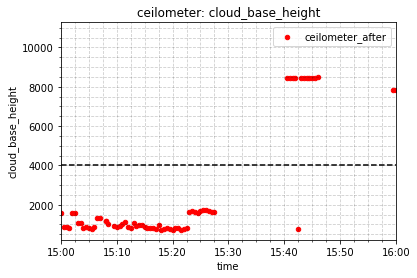

In [440]:
fig, ax = plt.subplots()
ceilometer_after.reset_index().plot(kind='scatter', x='time', y='cloud_base_height', use_index=True, ax=ax, color='r', label='ceilometer_after')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(title='ceilometer: cloud_base_height')
ax.legend()
ax.set_xlim(timeStart, timeEnd)
ax.axhline(4000, linestyle='--', color='k')
plt.minorticks_on()
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.2)
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)

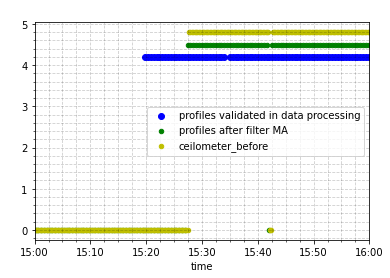

In [441]:
fig, ax = plt.subplots()

ax.scatter(pd.to_datetime(profiles_validated1.iloc[112,]), [4.2]*len(profiles_validated1.iloc[-2,]), color='b', label='profiles validated in data processing')
(list_time_indice*4.5).reset_index().plot(kind='scatter', x='index', y='indice', ax=ax, color='g', label='profiles after filter MA')

# ceilometer_after.reset_index().plot(kind='scatter', x='time', y='cloud_base_height', use_index=True, ax=ax, color='r', label='ceilometer_after')
(ceilometer_before*4.8).reset_index().plot(kind='scatter', x='time', y='cloud_base_height', use_index=True, ax=ax, color='y', label='ceilometer_before')
ax.set_xlim(timeStart, timeEnd)
ax.set(xlabel='time', ylabel=' ', title= ' ')
# ax.set_ylim(0,20000)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend()
plt.minorticks_on()
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.2)
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)

In [6]:
year = Path('2018')
IPRAL_PATH = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/', year)
#----------------------------------------------------
# sur tous les fichiers 
altmax = 4000 #m
list_time_indice = None
list_file_error = []
IPRAL_LISTFILES = sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))
for filepath in IPRAL_LISTFILES:
    try :
        mask_profile, ipral_noclouds, ceilometer_before, ceilometer_after = ipral_remove_cloud_profiles(altmax, filepath)
        mask_profile = pd.DataFrame(mask_profile).astype(int)
        if list_time_indice is None:
            list_time_indice = mask_profile
        else:
            list_time_indice = pd.concat([list_time_indice, mask_profile])
    except KeyError:
        list_file_error.append(filepath)
        pass
    

Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/02/21/chm15k_1a_z1Ppr2R15mF15s_v01_20180221_000000_1440.nc
817 in IPRAL data
25 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/02/22/chm15k_1a_z1Ppr2R15mF15s_v01_20180222_000000_1440.nc
1046 in IPRAL data
1 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/02/23/chm15k_1a_z1Ppr2R15mF15s_v01_20180223_000000_1440.nc
1234 in IPRAL data
0 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/02/24/chm15k_1a_z1Ppr2R15mF15s_v01_20180224_000000_1440.nc
2844 in IPRAL data
0 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/02/25/chm15k_1a_z1Ppr2R15mF15s_v01_2018

829 in IPRAL data
551 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/06/20/chm15k_1a_z1Ppr2R15mF15s_v01_20180620_000000_1440.nc
1845 in IPRAL data
51 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/06/21/chm15k_1a_z1Ppr2R15mF15s_v01_20180621_000000_1440.nc
2255 in IPRAL data
696 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/06/22/chm15k_1a_z1Ppr2R15mF15s_v01_20180622_000000_1440.nc
1476 in IPRAL data
104 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/06/25/chm15k_1a_z1Ppr2R15mF15s_v01_20180625_000000_1440.nc
1611 in IPRAL data
121 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1

2751 in IPRAL data
477 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/09/10/chm15k_1a_z1Ppr2R15mF15s_v01_20180910_000000_1440.nc
1810 in IPRAL data
1 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/09/11/chm15k_1a_z1Ppr2R15mF15s_v01_20180911_000000_1440.nc
2381 in IPRAL data
0 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/09/12/chm15k_1a_z1Ppr2R15mF15s_v01_20180912_000000_1440.nc
1719 in IPRAL data
112 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/09/14/chm15k_1a_z1Ppr2R15mF15s_v01_20180914_000000_1440.nc
1329 in IPRAL data
243 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/

CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/11/14/chm15k_1a_z1Ppr2R15mF15s_v01_20181114_000000_1440.nc
2851 in IPRAL data
606 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/11/15/chm15k_1a_z1Ppr2R15mF15s_v01_20181115_000000_1440.nc
1006 in IPRAL data
917 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/12/13/chm15k_1a_z1Ppr2R15mF15s_v01_20181213_000000_1440.nc
925 in IPRAL data
10 profiles will be remove
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/12/14/chm15k_1a_z1Ppr2R15mF15s_v01_20181214_000000_1440.nc
1752 in IPRAL data
244 profiles will be remove


In [44]:
# list_time_indice.to_csv('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/clouds_list_under_4000.csv')


## Verify SR distribution processing 

In [32]:
allsr355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr355-3000-4000.nc')
allsr532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles3_allsr532-3000-4000.nc')

In [34]:
xr_concat = xr.concat([allsr355['__xarray_dataarray_variable__'], allsr532['__xarray_dataarray_variable__']], dim='wavelength')#.set_index()
# xrnight = xr_concat.where(((xr_concat.time.dt.hour>=18)|(xr_concat.time.dt.hour<6)), drop=True)

# xrnight355 = allsr355.where(((xr_concat.time.dt.hour>=18)|(xr_concat.time.dt.hour<6)), drop=True)['__xarray_dataarray_variable__']
# xrnight532 = allsr532.where(((xr_concat.time.dt.hour>=18)|(xr_concat.time.dt.hour<6)), drop=True)['__xarray_dataarray_variable__']
# xrday355 = allsr355.where(((xr_concat.time.dt.hour>=6)&(xr_concat.time.dt.hour<18)), drop=True)['__xarray_dataarray_variable__']
# xrday532 = allsr532.where(((xr_concat.time.dt.hour>=6)&(xr_concat.time.dt.hour<18)), drop=True)['__xarray_dataarray_variable__']
# dfnight = pd.concat([allsr355['__xarray_dataarray_variable__'].drop('wavelength').to_dataframe(['sr355']), allsr532['__xarray_dataarray_variable__'].drop('wavelength').to_dataframe(['sr532'])], axis='index')
# df_concat = df_concat.reset_index(level='range')
# df_concat['hour'] = df_concat.index.hour

In [66]:
def get_params_histogram(srlimite, X532, Y355):
    if len(X532[np.where(~np.isnan(X532))]) > len(Y355[np.where(~np.isnan(Y355))]):
        H = np.histogram2d(X532[~np.isnan(Y355)], Y355[~np.isnan(Y355)], bins=100, range = srlimite)
        print('A')
        Hprobas = H[0]*100/len(Y355[~np.isnan(Y355)])
        noNaNpoints = len(Y355[~np.isnan(Y355)])
    elif len(X532[np.where(~np.isnan(X532))]) < len(Y355[np.where(~np.isnan(Y355))]):
        H = np.histogram2d(X532[~np.isnan(X532)], Y355[~np.isnan(X532)], bins=100, range = srlimite)
        print('B')
        Hprobas = H[0]*100/len(X532[~np.isnan(X532)])
        noNaNpoints = len(Y355[~np.isnan(Y355)])
    else:
        H = np.histogram2d(X532[np.where(~np.isnan(X532))], Y355[np.where(~np.isnan(Y355))], bins=100, range = srlimite)
        print('C')
        Hprobas = H[0]*100/len(X532[~np.isnan(X532)])
        noNaNpoints = len(X532[~np.isnan(X532)])
    print(f'nombre de points no-NaN: {noNaNpoints}')
    xedges, yedges = np.meshgrid(H[1], H[2])
    return xedges, yedges, Hprobas, noNaNpoints

<IPython.core.display.Javascript object>


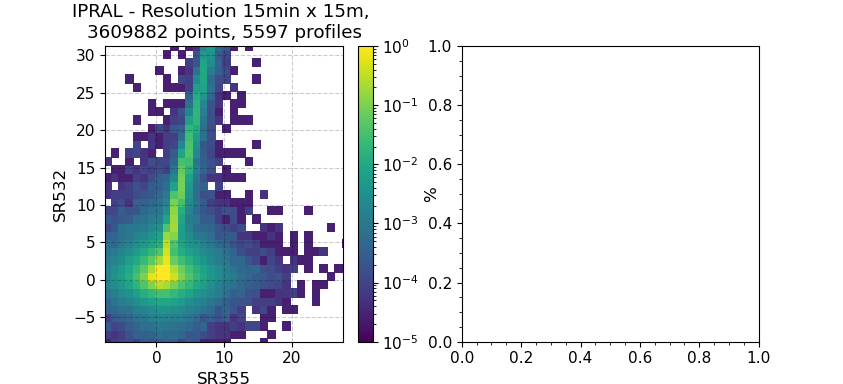

C
nombre de points no-NaN: 3609882


In [37]:
%matplotlib notebook
from matplotlib.colors import LogNorm
from scipy import stats

Y532 = allsr532['__xarray_dataarray_variable__']#xrnight532.values.ravel()
X355 = allsr355['__xarray_dataarray_variable__']#xrnight355.values.ravel()
ff, (ax,ax2) = plt.subplots(figsize=[12,5], ncols=2)
plt.minorticks_on()
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
'''
DAY
'''
Xxedges, Yyedges, probas, points = get_params_histogram(sr_limite, X355.values.ravel(), Y532.values.ravel())
p = ax.pcolormesh(Xxedges, Yyedges, probas.T, norm = LogNorm(vmax=1e0, vmin=1e-5))
# ax.plot(X532[np.where(~np.isnan(X532))], fitLine2, '-.', c='r')
c = plt.colorbar(p, ax=ax, label='%')
ax.set(ylabel='SR532', xlabel='SR355', 
       title= f'IPRAL - Resolution 15min x 15m, \n{points} points, {len(allsr532.time)} profiles')#\nLinearRegression: {round(slope,5)}x + {round(intercept,3)}
ax.set(xlim=(-5,40), ylim=(-10,80))
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.2)
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)
# '''
# NIGHT
# '''
# Xxedges, Yyedges, probas, points = get_params_histogram(sr_limite, xrnight532.values.ravel(), xrnight355.values.ravel())
# p = ax2.pcolormesh(Xxedges, Yyedges, probas.T, norm = LogNorm(vmax=1e0, vmin=1e-5))
# # ax.plot(X532[np.where(~np.isnan(X532))], fitLine2, '-.', c='r')
# c = plt.colorbar(p, ax=ax2, label='%')
# ax2.set(xlabel='SR532', ylabel='SR355', 
#        title= f'IPRAL - NIGHT, \n{points} points, {len(allsr532.time)} profiles')#\nLinearRegression: {round(slope,5)}x + {round(intercept,3)}
# ax2.set(xlim=(-10,sr_limite), ylim=(-10,sr_limite))
# plt.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.2)
# plt.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)

In [102]:
# allsr532 = allsr532['__xarray_dataarray_variable__']
# allsr355 = allsr355['__xarray_dataarray_variable__']
allsr355supp = allsr355.where((allsr532 >10))
allsr532supp = allsr532.where((allsr532 >10))

In [103]:
# np.where(~np.isnan(allsr532['__xarray_dataarray_variable__'].values.ravel())&~np.isinf(allsr532['__xarray_dataarray_variable__'].values.ravel()))#,np.where(np.isnan(allsr355['__xarray_dataarray_variable__'].values.ravel()))

# Y = allsr532['__xarray_dataarray_variable__'].values.ravel()[~np.isnan(allsr532['__xarray_dataarray_variable__'].values.ravel())&~np.isinf(allsr532['__xarray_dataarray_variable__'].values.ravel())]
# X = allsr355['__xarray_dataarray_variable__'].values.ravel()[~np.isnan(allsr532['__xarray_dataarray_variable__'].values.ravel())&~np.isinf(allsr532['__xarray_dataarray_variable__'].values.ravel())]

Y = allsr532supp.values.ravel()[~np.isnan(allsr532supp.values.ravel())&~np.isinf(allsr532supp.values.ravel())]
X = allsr355supp.values.ravel()[~np.isnan(allsr532supp.values.ravel())&~np.isinf(allsr532supp.values.ravel())]

# Test function with coefficients as parameters
def test(x, a, b):
    return a * x + b 

from scipy.optimize import curve_fit
param, param_cov = curve_fit(test, X, Y, p0=[0,0])
print(param, param_cov)

[ 4.11964154 -1.78043916] [[ 2.84457661e-05 -1.44012226e-04]
 [-1.44012226e-04  1.08674018e-03]]


In [110]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(param_cov))
print(stdevs)

[0.00533346 0.03296574]


In [114]:
from scipy import stats
# Define confidence interval.
ci = 0.95
# Convert to percentile point of the normal distribution.
# See: https://en.wikipedia.org/wiki/Standard_score
pp = (1. + ci) / 2.
# Convert to number of standard deviations.
nstd = stats.norm.ppf(pp)
print(nstd)

1.959963984540054


In [115]:
param_up = param + nstd*stdevs
param_down = param - nstd*stdevs

In [120]:
def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb


In [121]:
predband(np.linspace(0, 20, 50), X, Y, param, test, conf=0.95)

(array([-8.78098202, -7.09946472, -5.41795002, -3.73643793, -2.05492843,
        -0.37342153,  1.30808276,  2.98958446,  4.67108355,  6.35258004,
         8.03407393,  9.71556523, 11.39705392, 13.07854001, 14.7600235 ,
        16.44150439, 18.12298267, 19.80445836, 21.48593145, 23.16740193,
        24.84886982, 26.5303351 , 28.21179779, 29.89325787, 31.57471535,
        33.25617024, 34.93762252, 36.6190722 , 38.30051928, 39.98196376,
        41.66340564, 43.34484492, 45.0262816 , 46.70771568, 48.38914716,
        50.07057604, 51.75200232, 53.433426  , 55.11484708, 56.79626556,
        58.47768144, 60.15909472, 61.84050541, 63.52191349, 65.20331897,
        66.88472185, 68.56612214, 70.24751982, 71.92891491, 73.6103074 ]),
 array([ 5.22010369,  6.90155907,  8.58301706, 10.26447764, 11.94594083,
        13.62740661, 15.308875  , 16.99034599, 18.67181958, 20.35329576,
        22.03477455, 23.71625594, 25.39773994, 27.07922653, 28.76071572,
        30.44220751, 32.12370191, 33.8051989 , 35

C
nombre de points no-NaN: 35665


<IPython.core.display.Javascript object>


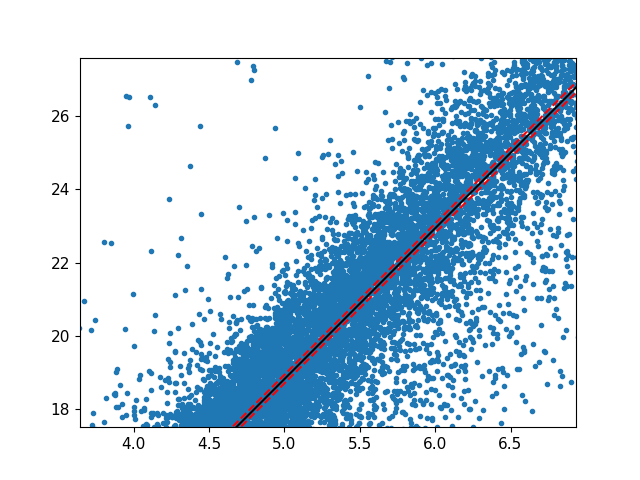

In [119]:
sr_limite = [[-10,40],[-10,100]]
XH, YH, probas, points = get_params_histogram(sr_limite, X, Y)

%matplotlib notebook
fig, ax = plt.subplots()
ax.plot(X, Y, '.')
xX = np.linspace(0, 20, 50)
# p = ax.pcolormesh(XH, YH, probas.T, norm = LogNorm())
ax.plot(xX, test(xX, *param), color='k')
ax.plot(xX, test(xX, *param_up), color='r', linestyle='--')
ax.plot(xX, test(xX, *param_down), color='r', linestyle='--')
# c = plt.colorbar(p, ax=ax, label='%')

C
nombre de points no-NaN: 3609882


<IPython.core.display.Javascript object>


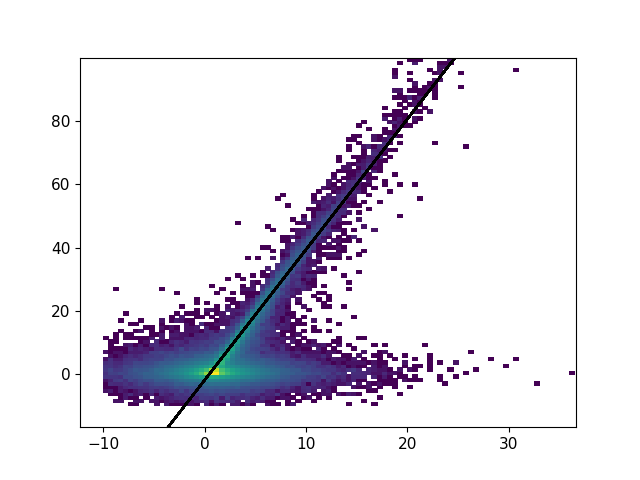

In [109]:
allsr532_new = test(allsr355.values.ravel(), *param)
sr_limite = [[-10,40],[-10,100]]
XH, YH, probas, points = get_params_histogram(sr_limite, allsr355.values.ravel(), allsr532.values.ravel())

f, ax = plt.subplots()
p = ax.pcolormesh(XH, YH, probas.T, norm = LogNorm())
ax.plot(X, test(X, *param), color='k')
# ax.plot(allsr355.values.ravel(), test(allsr355.values.ravel(), *param), color='r')

*Illustration le filtre sur un fichier de données:*
dont le ql est en "Range and Background corrected signal" et scatter plot représente la fraction par profil avec le seuil de filtrage. Les profils gardés, dits validés, a la fraction supérieur à seuil. 

## Distribution ATB532 & ATB355

In [122]:
allatb355 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles4_allatb355.nc')
allatb532 = xr.open_dataset('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/IPRAL_2018_validated_profiles4_allatb532.nc')

In [123]:
allatb355

<xarray.Dataset>
Dimensions:     (range: 666, time: 6596)
Coordinates:
  * time        (time) datetime64[ns] 2018-02-21T12:00:00 ... 2018-12-14T12:4...
  * range       (range) float32 5.01e+03 5.025e+03 ... 1.497e+04 1.498e+04
    wavelength  int64 ...
Data variables:
    calibrated  (time, range) float64 ...

In [142]:
np.log(X355)[~np.isnan(np.log(X355))].max()

<ipython-input-142-309edbfd1fd3>:1: RuntimeWarning: divide by zero encountered in log
  np.log(X355)[~np.isnan(np.log(X355))].max()
<ipython-input-142-309edbfd1fd3>:1: RuntimeWarning: invalid value encountered in log
  np.log(X355)[~np.isnan(np.log(X355))].max()


-3.407938499054782

<IPython.core.display.Javascript object>


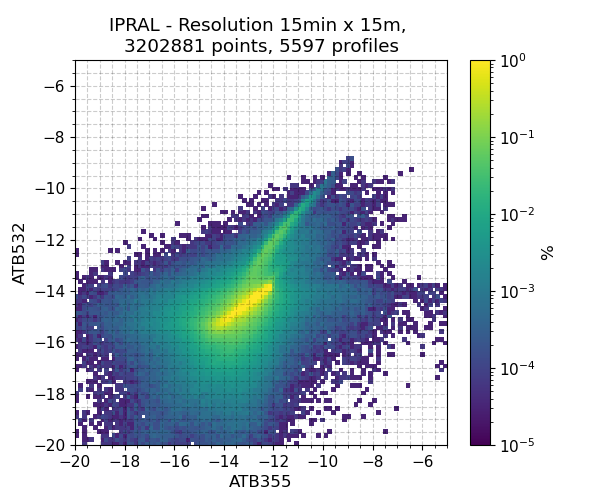

<ipython-input-153-277586e910de>:13: RuntimeWarning: divide by zero encountered in log
  Xxedges, Yyedges, probas, points = get_params_histogram([[-20, -5],[-20, -5]], np.log(X355), np.log(Y532))
<ipython-input-153-277586e910de>:13: RuntimeWarning: invalid value encountered in log
  Xxedges, Yyedges, probas, points = get_params_histogram([[-20, -5],[-20, -5]], np.log(X355), np.log(Y532))


B
nombre de points no-NaN: 3202881


In [153]:
%matplotlib notebook
from matplotlib.colors import LogNorm
from scipy import stats

Y532 = allatb532['calibrated'].values.ravel()
X355 = allatb355['calibrated'].values.ravel()
ff, ax = plt.subplots(figsize=[6,5])
plt.minorticks_on()
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12


Xxedges, Yyedges, probas, points = get_params_histogram([[-20, -5],[-20, -5]], np.log(X355), np.log(Y532))
p = ax.pcolormesh(Xxedges, Yyedges, probas.T, norm = LogNorm(vmax=1e0, vmin=1e-5))
# ax.plot(X532[np.where(~np.isnan(X532))], fitLine2, '-.', c='r')
c = plt.colorbar(p, ax=ax, label='%')
ax.set(ylabel='ATB532', xlabel='ATB355', 
       title= f'IPRAL - Resolution 15min x 15m, \n{points} points, {len(allsr532.time)} profiles')#\nLinearRegression: {round(slope,5)}x + {round(intercept,3)}
# ax.set(xlim=(-5,40), ylim=(-10,80))
ax.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.2)
ax.grid(b=True, which='major', color='k', linestyle='--', alpha=0.2)


## check flagcode

In [4]:
!cat /scratchx/nmpnguyen/IPRAL/raw/detection_clouds_test/detection_clouds_and_flags.py

## Ce script est pour appliquer la méthode de détection des nuages sur la base de données IPRAL

# Date: _2021.10.19_
# Author: _Phuong Nguyen_ 

import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import tqdm
import warnings
warnings.filterwarnings("ignore")

'''
tester flag code et verifier avec les quicklooks
enregistrer les quicklooks sur /scratchx/nmpnguyen/IPRAL/raw/
'''

def filter_profile_file(raw, channel, limiteTop, limiteBottom):
    '''
    Critere 1: flagger si le signal en haut plus qu'en bas
    '''
    # 1. CORRIGER RANGE CORRECTED SIGNAL WITH BACKGROUND
    filecorrected = raw #(raw[channel]/np.square(raw['range']) - raw['bckgrd_'+channel])*np.square(raw['range'])
    # 2. MEAN TOP AND BOTTOM SIGNAL
    limite = (raw['range']>limiteTop[0]) & (raw['range']<limiteTop[1])
    meanTop = filecorrected.isel(range=limite).mean(dim='range')
    limite = (raw['range']>limiteBottom[

In [9]:
year = Path('2018')
IPRAL_PATH = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/', year)
IPRAL_LISTFILES = sorted(IPRAL_PATH.glob('**/**/ipral_1a_Lz1R15mF30sPbck_v01_*_000000_1440.nc'))
print('#_______insert npy file to study list of bugs______')
listdatenpy = np.unique(pd.to_datetime(np.load('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/time_sr355.40_sr532.0.npy')).strftime('%Y%m%d'))
print(listdatenpy)
IPRAL_LISTFILES = [sorted(IPRAL_PATH.glob(f'**/**/ipral_1a_Lz1R15mF30sPbck_v01_{l}_000000_1440.nc'))[0] for l in listdatenpy]
print(len(IPRAL_LISTFILES))

#_______insert npy file to study list of bugs______
['20180222' '20180717' '20180725' '20180726' '20180909' '20181106'
 '20181214']
7


In [27]:
wave=355

data = xr.open_dataset(IPRAL_LISTFILES[3])

rcs_channel = 'rcs_12' if wave == 355 else 'rcs_16'
datacorrected = (data[rcs_channel]/np.square(data['range']) - data['bckgrd_'+rcs_channel])*np.square(data['range'])


In [54]:
# par CRIT 1
range_limite_top = [26000,28000]
range_limite_bottom = [2000,3000]
mask_crit1 = filter_profile_file(datacorrected, rcs_channel, range_limite_top, range_limite_bottom)
mask_crit1 = np.where(mask_crit1)[0]
# par CRIT 2
mask_crit2 = invalidated_profile(datacorrected.values)
mask_crit2 = np.where(mask_crit2)[0]
# par CRIT 3
rangeLimiteZ=[3000, 20000]
id_Z = np.where((data['range']>rangeLimiteZ[0])&(data['range']<rangeLimiteZ[1]))[0]
mask_crit3 = np.where(ipral_remove_cloud_profiles(1000, IPRAL_LISTFILES[3])) #flag_clouds(datacorrected, id_Z, IPRAL_LISTFILES[3], wave=wave) #
# mask_crit3 = np.where(~mask_crit3)[0]
# TOTAL INDICES
total_mask = np.intersect1d(np.intersect1d(mask_crit1, mask_crit2, return_indices=True)[0], 
                            mask_crit3, return_indices=True)[0]
time_to_save = data['time'][total_mask].values
print(f'wave = {wave}\ntime to save : {time_to_save}')


Removing IPRAL profiles with clouds below  1000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/07/26/chm15k_1a_z1Ppr2R15mF15s_v01_20180726_000000_1440.nc
1030 in IPRAL data
1030
1023
7 profiles will be remove
wave = 355
time to save : ['2018-07-26T08:02:46.000000000' '2018-07-26T08:03:15.999999744'
 '2018-07-26T08:03:46.000000000' '2018-07-26T08:04:17.000000000'
 '2018-07-26T08:04:47.000000000' '2018-07-26T08:05:16.999999744'
 '2018-07-26T08:05:48.000000256' '2018-07-26T08:06:18.000000000'
 '2018-07-26T08:06:48.000000000' '2018-07-26T08:07:17.999999744'
 '2018-07-26T08:07:49.000000256' '2018-07-26T08:08:19.000000000'
 '2018-07-26T08:08:49.000000000' '2018-07-26T08:09:20.000000000'
 '2018-07-26T08:09:50.000000256' '2018-07-26T08:10:20.000000000'
 '2018-07-26T08:10:51.000000000' '2018-07-26T08:11:21.000000000'
 '2018-07-26T08:11:51.000000256' '2018-07-26T08:12:21.000000000'
 '2018-07-26T08:12:52.000000000' '2018-07-26T08:13:22.000000000'
 '2018-07-26T08:13:52.000000256' '20

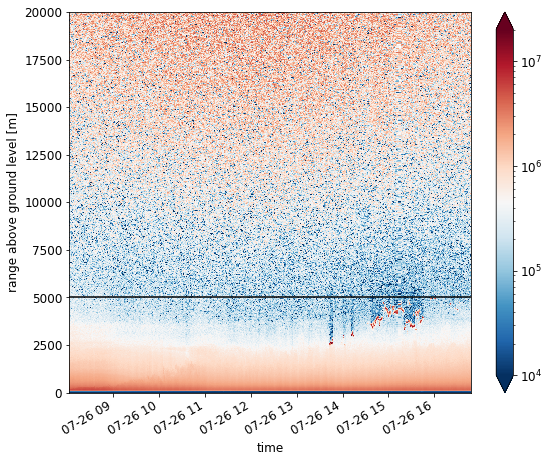

In [46]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(9,7))
plt.rcParams['font.size']=12
datacorrected.plot(y='range', x='time', ax=ax, norm=LogNorm(vmin=1e4), robust=True, ylim=(0,20000))
# ax.axvline(np.array(time_to_save, dtype='datetime64[ns]'), color='white', linestyle='--')
# ax.axvline(np.array(time_to_save[1], dtype='datetime64[ns]'), color='white', linestyle='--')
ax.axhline(5000, color='k')

In [61]:
pd.DataFrame([time_to_save, time_to_save[:10]]).to_csv('test.csv', index=False, mode='w')

### Verifier profils bugs

In [19]:
print('#_______insert npy file to study list of bugs______')
listdatenpy = np.unique(pd.to_datetime(np.load('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/time_sr355.40_sr532.0.npy')).strftime('%Y%m%d'))
print(listdatenpy)
IPRAL_LISTFILES = [sorted(IPRAL_PATH.glob(f'**/**/ipral_1a_Lz1R15mF30sPbck_v01_{l}_000000_1440.nc'))[0] for l in listdatenpy]
print(IPRAL_LISTFILES)
list_times_final = []
file = IPRAL_LISTFILES[0]
# # for file in tqdm.tqdm(IPRAL_LISTFILES[3:5]):
# #     # idsmask1, idsmask2, idsmask3, idsmask_total = processed(IPRAL_PATH, OUTPUT_PATH, file, rangeLimiteZ=[3000, 20000], wave=532)
time_to_save532 = processed(IPRAL_PATH, file, rangeLimiteZ=[2000, 20000], wave=532)
time_to_save355 = processed(IPRAL_PATH, file, rangeLimiteZ=[2000, 20000], wave=355)
list_times_final.append(np.intersect1d(time_to_save532, time_to_save355))

#_______insert npy file to study list of bugs______
['20180222' '20180717' '20180725' '20180726' '20180909' '20181106'
 '20181214']
[PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/02/22/ipral_1a_Lz1R15mF30sPbck_v01_20180222_000000_1440.nc'), PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/07/17/ipral_1a_Lz1R15mF30sPbck_v01_20180717_000000_1440.nc'), PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/07/25/ipral_1a_Lz1R15mF30sPbck_v01_20180725_000000_1440.nc'), PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/07/26/ipral_1a_Lz1R15mF30sPbck_v01_20180726_000000_1440.nc'), PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/09/09/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc'), PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/11/06/ipral_1a_Lz1R15mF30sPbck_v01_20181106_000000_1440.nc'), PosixPath('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/12/14/ipral_1a_Lz1R15mF30sPbck_v01_20181214_000000_1440.nc')]
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub

Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/02/22/chm15k_1a_z1Ppr2R15mF15s_v01_20180222_000000_1440.nc
1046 in IPRAL data
1046
1039
8 profiles will be remove
wave = 355
time to save : ['2018-02-22T16:02:05.000000000' '2018-02-22T16:08:39.000000000'
 '2018-02-22T16:19:46.000000000' '2018-02-22T16:21:47.000000000'
 '2018-02-22T16:26:19.000000256' '2018-02-22T16:27:50.000000000'
 '2018-02-22T16:44:30.000000000' '2018-02-22T16:45:00.000000000'
 '2018-02-22T16:50:03.000000000' '2018-02-22T16:53:34.999999744'
 '2018-02-22T16:54:36.000000000' '2018-02-22T16:57:07.000000000'
 '2018-02-22T17:11:46.000000000' '2018-02-22T17:12:16.000000000'
 '2018-02-22T17:19:20.000000000' '2018-02-22T17:27:54.999999744'
 '2018-02-22T17:34:59.000000000' '2018-02-22T17:36:00.000000000'
 '2018-02-22T18:03:16.000000000' '2018-02-22T18:09:19.000000000'
 '2018-02-22T18:18:55.000000000' '2018-02-22T18:19:24.999999744'
 '2018-02-22T18:42:08.000000000' '20

In [20]:
data = xr.open_dataset(file)
print(len(list_times_final[0]), len(data['time'].values))
time_valid = list_times_final[0]
time_no_valid = np.setxor1d(time_valid, data['time'].values)
print(len(time_valid), len(time_no_valid))

44 1046
44 1002


In [5]:
# profils = pd.read_csv('/scratchx/nmpnguyen/IPRAL/raw/detection_clouds_test/IPRAL_2018_validated_profiles3.csv')

In [73]:
profiles_bug = np.load('/scratchx/nmpnguyen/IPRAL/raw/SR_histogram/time_sr355.40_sr532.0_v3.npy')
profiles_bug = profiles_bug[pd.to_datetime(profiles_bug).strftime('%Y%m%d')=='20181214']
len(profiles_bug), profiles_bug

(21,
 array(['2018-12-14T12:52:13.000000000', '2018-12-14T13:17:27.000000000',
        '2018-12-14T13:17:27.000000000', '2018-12-14T13:32:06.000000000',
        '2018-12-14T13:36:39.000000000', '2018-12-14T13:39:10.000000000',
        '2018-12-14T13:40:10.999999744', '2018-12-14T13:45:14.000000000',
        '2018-12-14T13:45:14.000000000', '2018-12-14T13:53:49.000000000',
        '2018-12-14T14:02:54.000000000', '2018-12-14T14:11:29.000000000',
        '2018-12-14T14:14:30.000000000', '2018-12-14T14:15:01.000000000',
        '2018-12-14T14:16:01.000000000', '2018-12-14T14:19:03.000000000',
        '2018-12-14T14:21:35.000000000', '2018-12-14T14:25:07.000000256',
        '2018-12-14T14:35:12.000000000', '2018-12-14T14:38:44.000000000',
        '2018-12-14T14:43:17.000000000'], dtype='datetime64[ns]'))

In [71]:
print(len(np.intersect1d(profiles_bug, time_valid)))
print((np.intersect1d(profiles_bug, time_no_valid)))


0
['2018-12-14T12:52:13.000000000' '2018-12-14T13:17:27.000000000'
 '2018-12-14T13:32:06.000000000' '2018-12-14T13:36:39.000000000'
 '2018-12-14T13:39:10.000000000' '2018-12-14T13:40:10.999999744'
 '2018-12-14T13:45:14.000000000' '2018-12-14T13:53:49.000000000'
 '2018-12-14T14:02:54.000000000' '2018-12-14T14:11:29.000000000'
 '2018-12-14T14:14:30.000000000' '2018-12-14T14:15:01.000000000'
 '2018-12-14T14:16:01.000000000' '2018-12-14T14:19:03.000000000'
 '2018-12-14T14:21:35.000000000' '2018-12-14T14:25:07.000000256'
 '2018-12-14T14:35:12.000000000' '2018-12-14T14:38:44.000000000'
 '2018-12-14T14:43:17.000000000']


In [65]:
def sr_by_files(csv_listdates, calib_pathfolder):
    date_of_list = pd.to_datetime(csv_listdates[1]).strftime('%Y%m%d')
    IPRAL_FILE_MASK = f'ipral_1a_Lz1R15mF30sPbck_v01_{str(date_of_list)}_000000_1440.nc'
    file = sorted(calib_pathfolder.glob(f'{IPRAL_FILE_MASK}'))[0]
#     idfile = np.where([file.stem.split('_')[4] == str(date_of_list) for file in calib_listfiles])[0][0]
    datacalib = xr.open_dataset(file) 
    limiteZ = (datacalib['range']>5000)&(datacalib['range']<15000)
#     time_valid = np.intersect1d(datacalib['time'].values, np.array(pd.to_datetime(csv_listdates)))
#     time_valid = datacalib['time'][indice].values
    sr355 = (datacalib['calibrated']/datacalib['simulated']).sel(wavelength = 355)#, time=csv_listdates).isel(range=limiteZ)
    sr532 = (datacalib['calibrated']/datacalib['simulated']).sel(wavelength = 532)#, time=csv_listdates).isel(range=limiteZ)
#     print(np.where((sr355>39)&(sr355<40)&(sr532>0)&(sr532<1)))
    idx = np.where((sr355>39)&(sr355<40)&(sr532>0)&(sr532<1))
    time_outlier = sr355['time'].values[idx[0]]
    range_outlier = sr355['range'].values[idx[1]]
    return csv_listdates, time_outlier, range_outlier, sr355, sr532

In [66]:
time_valid_from_SR, time_outlier_from_SR, range_outlier_from_SR, SR355, SR532 = sr_by_files(csv_listdates = time_valid, calib_pathfolder = Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/'))
# print(np.setxor1d(time_valid_from_SR, time_valid))
print(np.intersect1d(time_outlier_from_SR, time_no_valid))
print((time_valid_from_SR))

['2018-02-22T11:15:40.999999744' '2018-02-22T11:20:44.000000000'
 '2018-02-22T11:26:47.999999744' '2018-02-22T11:45:29.000000000'
 '2018-02-22T11:46:29.000000000' '2018-02-22T11:56:35.000000256'
 '2018-02-22T12:00:07.000000000' '2018-02-22T12:01:07.999999744'
 '2018-02-22T12:37:28.999999744' '2018-02-22T12:46:34.000000000'
 '2018-02-22T13:07:46.000000000' '2018-02-22T13:12:19.000000000'
 '2018-02-22T13:13:19.000000256' '2018-02-22T13:25:57.000000000'
 '2018-02-22T13:42:36.000000000' '2018-02-22T13:44:37.000000000'
 '2018-02-22T14:13:24.000000000' '2018-02-22T14:14:24.000000000'
 '2018-02-22T14:17:57.000000256' '2018-02-22T15:59:04.000000000'
 '2018-02-22T16:00:35.000000000' '2018-02-22T16:01:05.000000000'
 '2018-02-22T16:04:07.000000000' '2018-02-22T16:05:38.000000000'
 '2018-02-22T16:06:08.000000000' '2018-02-22T16:09:40.000000000'
 '2018-02-22T16:10:40.000000000' '2018-02-22T16:11:41.000000000'
 '2018-02-22T16:12:42.000000000' '2018-02-22T16:14:43.000000000'
 '2018-02-22T16:15:12.999

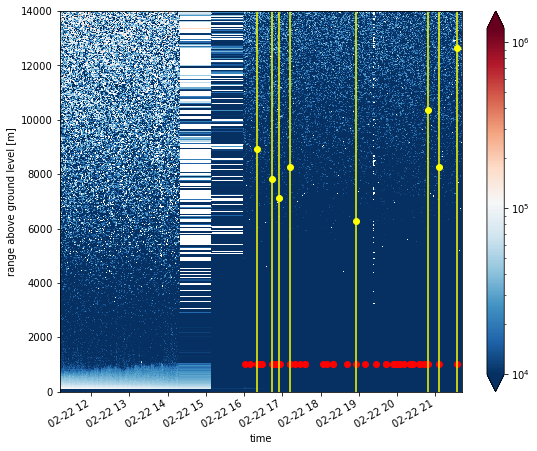

In [54]:
# from matplotlib.colors import LogNorm
# data = xr.open_dataset(IPRAL_LISTFILES[-1])
# datacorrected = (data['rcs_12']/np.square(data['range']) - data['bckgrd_'+'rcs_12'])*np.square(data['range'])

fig, ax = plt.subplots(figsize=(9,7))
datacorrected.plot(x='time', y='range', robust=True, ylim=(0,14000), norm=LogNorm(vmin=1e4), ax=ax)
ax.scatter(time_valid, np.array([1000]*len(time_valid)), color='r')
ax.scatter(time_outlier_from_SR, range_outlier_from_SR, color='yellow')
ax.vlines(np.array(time_outlier_from_SR, dtype='datetime64[ns]'),ymin=0, ymax=14000, color='yellow')

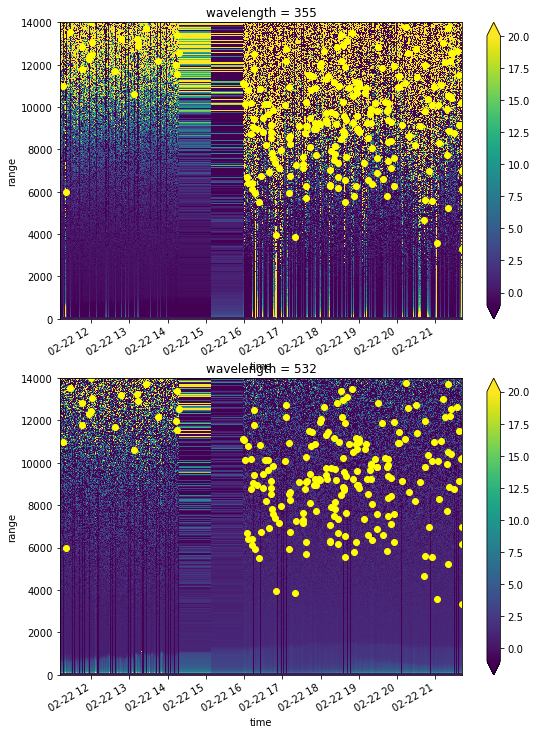

In [70]:
fig, (ax, ax2) = plt.subplots(figsize=(9,12), nrows=2)
SR355.plot(x='time', y='range', ax=ax, vmin=-1, vmax= 20, robust=True, ylim=(0,14000))
ax.scatter(time_outlier_from_SR, range_outlier_from_SR, color='yellow')
SR532.plot(x='time', y='range', ax=ax2, vmin=-1, vmax= 20, robust=True, ylim=(0,14000))
ax2.scatter(time_outlier_from_SR, range_outlier_from_SR, color='yellow')

## TEST DENOISING SIGNALS

In [3]:
#%% Simple example   
import numpy as np  
import matplotlib.pyplot as plt  
from vmdpy import VMD 

In [4]:
#. Time Domain 0 to T  
T = 1000  
fs = 1/T  
t = np.arange(1,T+1)/T  
freqs = 2*np.pi*(t-0.5-fs)/(fs)  
print(t, freqs)

[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024
 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035 0.036
 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047 0.048
 0.049 0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059 0.06
 0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071 0.072
 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083 0.084
 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095 0.096
 0.097 0.098 0.099 0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107 0.108
 0.109 0.11  0.111 0.112 0.113 0.114 0.115 0.116 0.117 0.118 0.119 0.12
 0.121 0.122 0.123 0.124 0.125 0.126 0.127 0.128 0.129 0.13  0.131 0.132
 0.133 0.134 0.135 0.136 0.137 0.138 0.139 0.14  0.141 0.142 0.143 0.144
 0.145 0.146 0.147 0.148 0.149 0.15  0.151 0.152 0.153 0.154 0.155 0.156
 0.157 0.158 0.159 0.16  0.161 0.162 0.163 0.164 0.16

In [5]:
#. center frequencies of components  
f_1 = 2  
f_2 = 24  
f_3 = 288  

#. modes  
v_1 = (np.cos(2*np.pi*f_1*t))  
v_2 = 1/4*(np.cos(2*np.pi*f_2*t))  
v_3 = 1/16*(np.cos(2*np.pi*f_3*t))  

f = v_1 + v_2 + v_3 + 0.1*np.random.randn(v_1.size)  

In [32]:
#. some sample parameters for VMD  
alpha = 2000       # moderate bandwidth constraint  
tau = 1.08            # noise-tolerance (no strict fidelity enforcement)  
K = 5            # 3 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-6  


In [33]:
#. Run actual VMD code  
u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)  

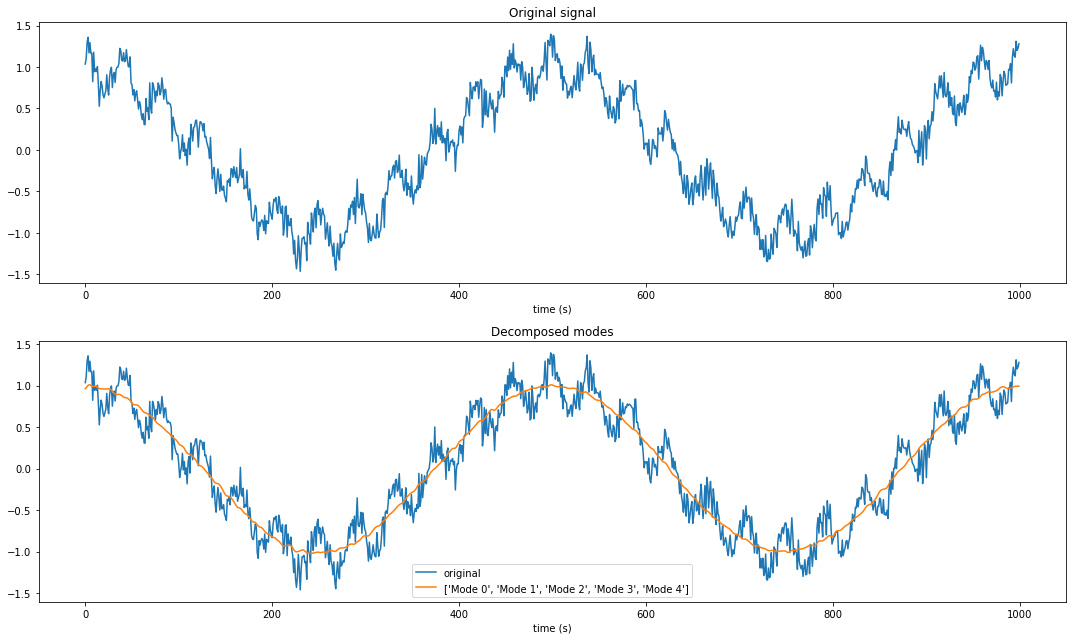

In [36]:
#. Visualize decomposed modes
plt.figure(figsize=(15,9))
plt.subplot(2,1,1)
plt.plot(f)
plt.title('Original signal')
plt.xlabel('time (s)')
plt.subplot(2,1,2)
plt.plot(f)
plt.plot(u[0])
# plt.plot(u.T)
plt.title('Decomposed modes')
plt.xlabel('time (s)')
# plt.legend(['original', 'decomposed'])
plt.legend(['original',['Mode %d'%m_i for m_i in range(u.shape[0])]])
plt.tight_layout()

In [181]:
data = xr.open_dataset(list(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/').glob('*20180224*1440.nc'))[0])
limitez = (data['range']<14000)&(data['range']>1000)
signal_to_vmd = (data['calibrated']/data['simulated']).isel(time=-2, wavelength=0, range=limitez)


In [182]:
#. some sample parameters for VMD  
alpha = 2050       # moderate bandwidth constraint  
tau = 1.22          # noise-tolerance (no strict fidelity enforcement)  
K = 6           #  modes  
DC = 0            # no DC part imposed  
init = 1          # initialize omegas uniformly  
tol = 1e-7  

#. Run actual VMD code  
u, u_hat, omega = VMD(signal_to_vmd, alpha, tau, K, DC, init, tol)  


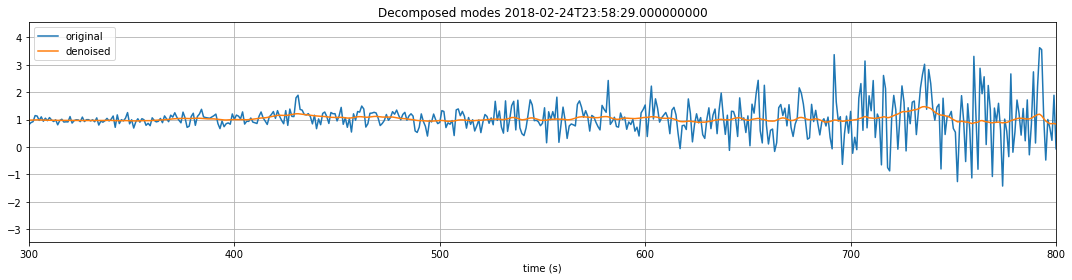

In [185]:
#. Visualize decomposed modes
plt.figure(figsize=(15,4))
plt.plot(signal_to_vmd)
plt.plot(u[0])
# plt.plot(u.T)
plt.title(f'Decomposed modes {signal_to_vmd.time.values}')
plt.xlabel('time (s)')
plt.legend(['original', 'denoised'])
# plt.legend(['original',['Mode %d'%m_i for m_i in range(u.shape[0])]])
plt.grid()
plt.xlim(300,800)
# plt.ylim(0,1.5)
plt.tight_layout()

In [184]:
rmse_compute = np.sqrt(1/len(signal_to_vmd)*np.sum(np.square(signal_to_vmd[1:] - u[0])))
print(rmse_compute.values, np.mean(signal_to_vmd))

0.6381928593806784 <xarray.DataArray ()>
array(1.12705042)
Coordinates:
    time        datetime64[ns] 2018-02-24T23:58:29
    wavelength  int64 355


In [165]:
def get_denoised_signal(signal_input):
    #. some sample parameters for VMD  
    alpha = 2000       # moderate bandwidth constraint  
    tau = 0.5          # noise-tolerance (no strict fidelity enforcement)  
    K = 6           #  modes  
    DC = 0            # no DC part imposed  
    init = 1          # initialize omegas uniformly  
    tol = 1e-7  
    
    #. Run actual VMD code  
    decomposed_signal, u_hat, omega = VMD(signal_to_vmd, alpha, tau, K, DC, init, tol)  
    return decomposed_signal[0], rmse_compute

In [146]:
data_to_vmd = (data['calibrated']/data['simulated']).isel(wavelength=0, range=limitez).values


In [139]:
denoised_data = np.array([get_denoised_signal(data_to_vmd[i,:]) for i in range(20)])

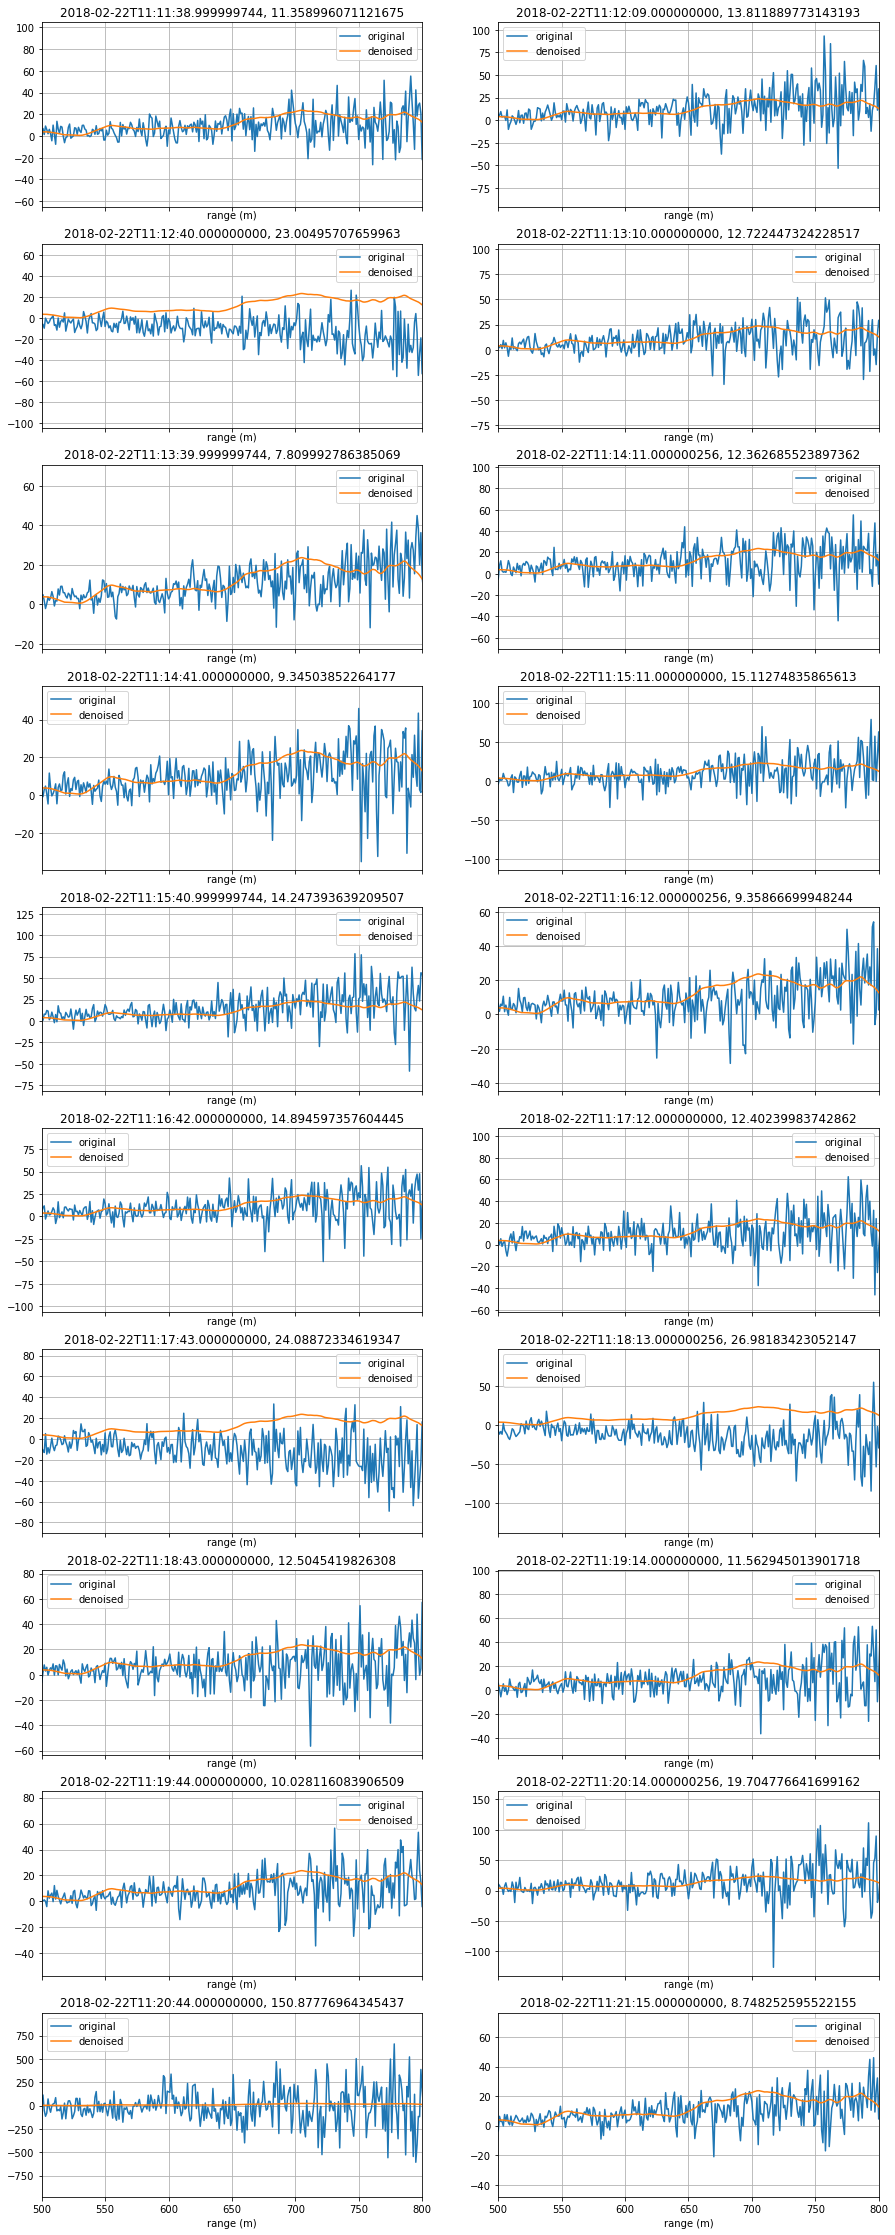

In [167]:
#. Visualize decomposed modes
fig, axs = plt.subplots(figsize=(15,4*10), ncols=2, nrows=10, sharex=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(data_to_vmd[i,:])
    ax.plot(denoised_data[i,:])
    rmse_signal = np.sqrt(1/len(data_to_vmd[i,:])*np.sum(np.square(data_to_vmd[i,1:]- denoised_data[i,:])))
    ax.set(title=f'{data.time.values[i]}, {rmse_signal}', xlabel='range (m)')
#     ax.xlabel('range (m)')
    ax.legend(['original', 'denoised'])
    # plt.legend(['original',['Mode %d'%m_i for m_i in range(u.shape[0])]])
    ax.grid()
    plt.xlim(500,800)
    # plt.ylim(0,1.5)
#     plt.tight_layout()

In [164]:
rmse_compute = np.sqrt(1/len(data_to_vmd)*np.sum(np.square(data_to_vmd[:20,1:] - denoised_data), axis=1))
print(rmse_compute, np.mean(signal_to_vmd))

[ 10.34150285  12.57467619  20.94426546  11.58282161   7.11040501
  11.25528583   8.50794752  13.75900909  12.97116937   8.52035521
  13.56039918  11.2914427   21.9309523   24.56490994  11.38443536
  10.52718286   9.12983774  17.93970193 137.3627453    7.96461928] <xarray.DataArray ()>
array(6.41425469)
Coordinates:
    time        datetime64[ns] 2018-02-22T12:52:37
    wavelength  int64 355


In [26]:
profiles_validated1 = pd.read_csv('/scratchx/nmpnguyen/IPRAL/raw/detection_clouds_test/IPRAL_2018_validated_profiles1.csv')


In [27]:
print(profiles_validated1.iloc[76])

Unnamed: 0       2018-09-09 00:00:20.000000000
Unnamed: 1       2018-09-09 00:00:50.000000000
Unnamed: 2       2018-09-09 00:01:21.000000000
Unnamed: 3       2018-09-09 00:01:50.999999744
Unnamed: 4       2018-09-09 00:02:21.000000000
                             ...              
Unnamed: 2817                              NaN
Unnamed: 2818                              NaN
Unnamed: 2819                              NaN
Unnamed: 2820                              NaN
Unnamed: 2821                              NaN
Name: 76, Length: 2822, dtype: object


In [28]:
selecttime = np.array(pd.to_datetime(profiles_validated1.iloc[76]))#.astype('datetime64[ns]')
selecttime = selecttime[~np.isnan(selecttime)]
selecttime[584]

numpy.datetime64('2018-09-09T05:00:42.000000000')

In [29]:
CALIB_PATH = Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/')
IPRAL_LISTFILES = sorted(CALIB_PATH.glob('**/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc'))
print(IPRAL_LISTFILES[0])

dataselect = xr.open_dataset(IPRAL_LISTFILES[0], decode_times=True)
limitez = dataselect['range'] < 20000
dataselect.isel(time=584)

/homedata/nmpnguyen/IPRAL/RF/Calibrated/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440.nc


<xarray.Dataset>
Dimensions:     (range: 4000, wavelength: 2)
Coordinates:
    time        datetime64[ns] 2018-09-09T05:00:12.000000256
  * range       (range) float32 15.0 30.0 45.0 ... 5.997e+04 5.998e+04 6e+04
  * wavelength  (wavelength) int64 355 532
Data variables:
    calibrated  (wavelength, range) float64 ...
    simulated   (wavelength, range) float64 ...
Attributes:
    calibration height:  [5000 7000]
    canal:               ['355-analog-NearField', '532-analog-NearField']
    Ipral_canal:         ['rcs_12', 'rcs_16']

[Text(0, 0.5, 'Altitude, m'),
 Text(0.5, 0, 'Time'),
 Text(0.5, 1.0, 'IPRAL - Attenuated backscatter\nipral_1a_Lz1R15mF30sPbck_v01_20180929_000000_1440\n')]

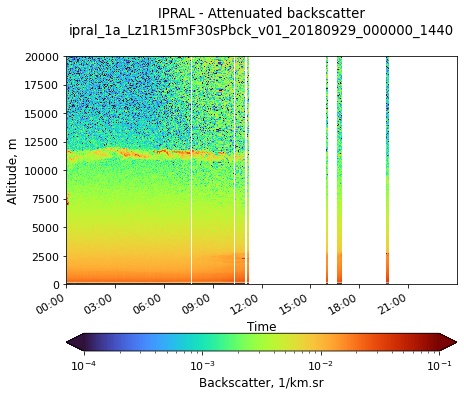

In [215]:
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
# Data_final = dataselect.sel(wavelength=355)['calibrated'].where(total_mask, drop=False)
fig, ax = plt.subplots(figsize=(7,6))
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
(Data_final*1e3).plot(x='time', y='range', norm=LogNorm(vmin=1e-4, vmax=1e-1), ax=ax, robust=True, cmap='turbo',
                   ylim=(0,20000), cbar_kwargs={'label':'Backscatter, 1/km.sr', 'orientation':'horizontal'})
# ax.scatter(datacorrected[index_mask]['time'].values, [19000]*len(datacorrected[index_mask]['time'].values), color='y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set(ylabel='Altitude, m', xlabel='Time',
      title=f'IPRAL - Attenuated backscatter\n{IPRAL_LISTFILES[0].stem}\n')

<xarray.Dataset>
Dimensions:     (range: 1333, wavelength: 2)
Coordinates:
    time        datetime64[ns] 2018-09-09T05:00:42
  * range       (range) float32 15.0 30.0 45.0 ... 1.996e+04 1.998e+04 2e+04
  * wavelength  (wavelength) int64 355 532
Data variables:
    calibrated  (wavelength, range) float64 ...
    simulated   (wavelength, range) float64 ...
Attributes:
    calibration height:  [5000 7000]
    canal:               ['355-analog-NearField', '532-analog-NearField']
    Ipral_canal:         ['rcs_12', 'rcs_16']


[Text(0.5, 0, 'Backscatter, 1/km.sr'),
 Text(0, 0.5, 'Range above ground level, m'),
 Text(0.5, 1.0, 'Total Attenuated Backscatter profile')]

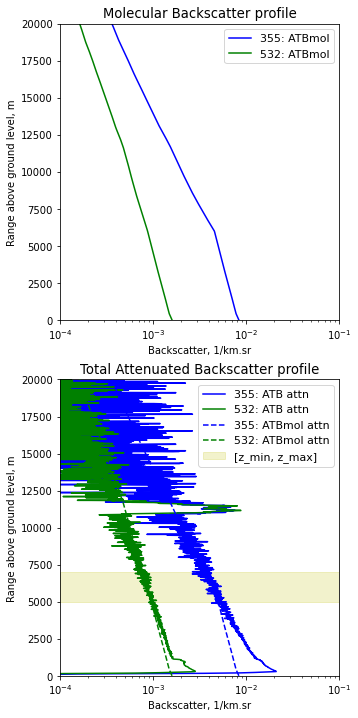

In [17]:
dataselected = dataselect.sel(time = selecttime[584]).isel(range=limitez)
print(dataselected)
fig, (ax, ax2) = plt.subplots(figsize=(5,12), nrows=2)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
(dataselected.sel(wavelength=355)['simulated']*1e3).plot(y='range', xlim=(1e-4, 1e-1), ylim=(0,20000), xscale='log',
                                                                label='355: ATBmol', color='b', ax=ax)
(dataselected.sel(wavelength=532)['simulated']*1e3).plot(y='range', xlim=(1e-4, 1e-1), ylim=(0,20000), xscale='log',
                                                                label='532: ATBmol', color='g', ax=ax)
ax.legend()
ax.set(xlabel='Backscatter, 1/km.sr', ylabel='Range above ground level, m', title='Molecular Backscatter profile')

(dataselected.sel(wavelength=355)['calibrated']*1e3).plot(y='range', xlim=(1e-4, 1e-1), ylim=(0,20000), xscale='log', zorder=2,
                                                                       label='355: ATB attn', color='b', ax=ax2)
(dataselected.sel(wavelength=532)['calibrated']*1e3).plot(y='range', xlim=(1e-4, 1e-1), ylim=(0,20000), xscale='log', zorder=2,
                                                                       label='532: ATB attn', color='g', ax=ax2)
(dataselected.sel(wavelength=355)['simulated']*1e3).plot(y='range', xlim=(1e-4, 1e-1), ylim=(0,20000), xscale='log', zorder=10,
                                                                label='355: ATBmol attn', color='b', linestyle='--', ax=ax2)
(dataselected.sel(wavelength=532)['simulated']*1e3).plot(y='range', xlim=(1e-4, 1e-1), ylim=(0,20000), xscale='log', zorder=12,
                                                                label='532: ATBmol attn', color='g', linestyle='--', ax=ax2)
ax2.axhspan(ymin=5000, ymax=7000, alpha=0.2, color='y', label='[z_min, z_max]')
ax2.legend()
ax2.set(xlabel='Backscatter, 1/km.sr', ylabel='Range above ground level, m', title='Total Attenuated Backscatter profile')


In [30]:
data_mean = dataselect.resample(time='15min').mean(dim='time')
data_mean.isel(time=31)

<xarray.Dataset>
Dimensions:     (range: 4000, wavelength: 2)
Coordinates:
    time        datetime64[ns] 2018-09-09T07:30:00
  * range       (range) float32 15.0 30.0 45.0 ... 5.997e+04 5.998e+04 6e+04
  * wavelength  (wavelength) int64 355 532
Data variables:
    calibrated  (wavelength, range) float64 3.706e-12 1.495e-11 ... 7.817e-07
    simulated   (wavelength, range) float64 8.37e-06 8.348e-06 ... -3.955e-09

<IPython.core.display.Javascript object>


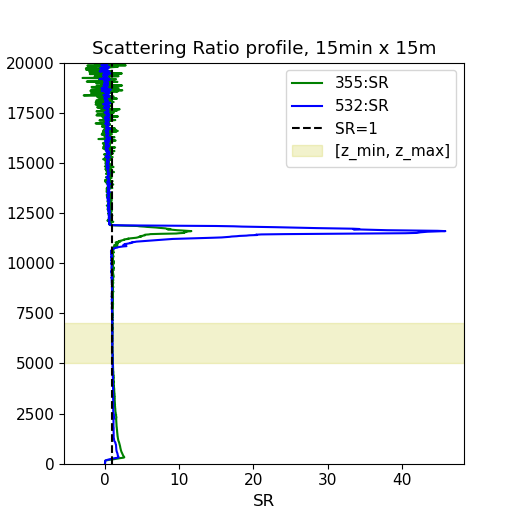

[Text(0.5, 0, 'SR'),
 Text(0, 0.5, 'Range above ground level, m'),
 Text(0.5, 1.0, 'Scattering Ratio profile, 15min x 15m')]

In [31]:
%matplotlib notebook 
import matplotlib.pyplot as plt

fig, ax2 = plt.subplots(figsize=(5,6))
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
(data_mean['calibrated']/data_mean['simulated']).isel(time=31, range=limitez).sel(wavelength=355).plot(y='range', ylim=(0,20000), ax=ax2,
                                                                         label='355:SR', color='g')
(data_mean['calibrated']/data_mean['simulated']).isel(time=31, range=limitez).sel(wavelength=532).plot(y='range', ylim=(0,20000), ax=ax2,
                                                                         label='532:SR', color='b')
ax2.axvline(1, linestyle='--', zorder=10, color='k', label='SR=1')
ax2.axhspan(ymin=5000, ymax=7000, alpha=0.2, color='y', label='[z_min, z_max]')
ax2.legend()
ax2.set(xlabel='SR', ylabel='Range above ground level, m', title='Scattering Ratio profile, 15min x 15m')


In [13]:
from skimage.measure import block_reduce

np.mean((data_mean['calibrated']/data_mean['simulated']).isel(time=31, range=limitez).values.reshape((-1, int(limitez.sum()/4))), axis=1)

ValueError: cannot reshape array of size 2666 into shape (333)

In [20]:
1333/3

444.3333333333333